# Idea
Do some training

In [1]:
SEED = 133

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

In [3]:
import sys
repo_base_path = Path("./../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = "single-layer_300"
LOG_NAME_EXPERIMENT_2 = "single-layer_30_from_weights"
LOG_NAME_EXPERIMENT_3 = "multi-layer_30_from_weights"

In [5]:
df = pd.read_csv('../data/all_df.csv')
df.set_index("timestamp", inplace=True)

In [6]:
df["label"].unique()

array(['1_normal', nan, '2_ransomware', '3_thetick', '4_bashlite',
       '5_httpbackdoor', '6_beurk', '7_backdoor', '8_bdvl', '9_xmrig'],
      dtype=object)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [7]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(43248, 306)
(25770, 306)


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [10]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [11]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [12]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

### Setup

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [14]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 2.8 K 
------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[ 91,   0,   0,   0,   0,   6,   0,   3,   4],
        [  0,   0,  15,   0,   7,   2,   0,  94,   0],
        [116,   0,   0,   0,   0,   4,   0,   4,   1],
        [105,   0,   0,   0,   0,   7,   0,   0,   2],
        [101,   0,   0,   0,   0,   0,   0,   0,   3],
        [115,   0,   0,   0,   0,   0,   0,   0,   0],
        [109,   0,   0,   0,   0,   4,   0,   3,   0],
        [ 61,   0,   0,   0,   0,   0,   0,  29,   0],
        [114,   0,   0,   0,   0,   0,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 680,   11,  398,  702,  498,   87,  271,    3,    4],
        [   0, 3213,   24,    0,   13,    3,    0,  145,    0],
        [ 330,   81, 1634,  273,  343,  371,  268,    4,    1],
        [ 503,    9,  461,  913,  504,   71,  297,    0,    6],
        [ 360,   12,  303,  492, 1298,   56,  292,    0,    6],
        [ 184,  179,   28,    3,    2, 2531,    8,    0,    0],
        [ 401,   61, 1016,  343,  341,  240,  361,    3,    0],
        [  94,   21,    0,    0,    0,    0,    0, 2620,    0],
        [ 178,   15,    0,    0,   49,    0,   57,    0, 3095]])


Metric Validation/Accuracy improved. New best score: 0.700


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 680,   11,  398,  702,  498,   87,  271,    3,    4],
        [   0, 3213,   24,    0,   13,    3,    0,  145,    0],
        [ 330,   81, 1634,  273,  343,  371,  268,    4,    1],
        [ 503,    9,  461,  913,  504,   71,  297,    0,    6],
        [ 360,   12,  303,  492, 1298,   56,  292,    0,    6],
        [ 184,  179,   28,    3,    2, 2531,    8,    0,    0],
        [ 401,   61, 1016,  343,  341,  240,  361,    3,    0],
        [  94,   21,    0,    0,    0,    0,    0, 2620,    0],
        [ 178,   15,    0,    0,   49,    0,   57,    0, 3095]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[1772,   11,  556, 1438,  777,   87,  556,    3,    4],
        [   0, 6493,   24,    0,   13,    3,    0,  145,    0],
        [ 507,   81, 3791,  488,  620,  516,  477,    4,    1],
        [1005,    9,  729, 2195,  817,   71,  582,    0,    6],
        [ 477,   12,  476,  735, 3242,   72,  514,    0,    6],
        [ 186,  179,   56,    4,    8, 5313,    9,    0,    0],
        [ 647,   61, 2066,  660,  699,  340,  940,    3,    0],
        [  94,   21,    0,    0,    0,    0,    0, 5265,    0],
        [ 178,   15,    0,    0,   49,    0,   57,    0, 6375]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[1772,   11,  556, 1438,  777,   87,  556,    3,    4],
        [   0, 6493,   24,    0,   13,    3,    0,  145,    0],
        [ 507,   81, 3791,  488,  620,  516,  477,    4,    1],
        [1005,    9,  729, 2195,  817,   71,  582,    0,    6],
        [ 477,   12,  476,  735, 3242,   72,  514,    0,   

Metric Validation/Accuracy improved by 0.070 >= min_delta = 0.0. New best score: 0.770


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[3232,   11,  621, 2154,  851,   87,  791,    3,    4],
        [   0, 9773,   24,    0,   13,    3,    0,  145,    0],
        [ 679,   81, 6049,  652,  743,  628,  828,    4,    1],
        [1604,   10,  874, 3750,  882,   71,  867,    0,    6],
        [ 589,   12,  550,  838, 5468,   87,  699,    0,    6],
        [ 190,  183,   75,    4,    8, 8104,   11,    0,    0],
        [ 920,   61, 2965,  975,  897,  421, 1824,    3,    0],
        [  94,   21,    0,    0,    0,    0,    0, 7910,    0],
        [ 178,   15,    0,    0,   49,    0,   57,    0, 9655]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[3232,   11,  621, 2154,  851,   87,  791,    3,    4],
        [   0, 9773,   24,    0,   13,    3,    0,  145,    0],
        [ 679,   81, 6049,  652,  743,  628,  828,    4,    1],
        [1604,   10,  874, 3750,  882,   71,  867,    0,    6],
        [ 589,   12,  550,  838, 5468,   87,  699,    0,   

Metric Validation/Accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 4889,    11,   654,  2806,   873,    87,   977,     3,     4],
        [    0, 13053,    24,     0,    13,     3,     0,   145,     0],
        [  832,    81,  8421,   818,   802,   713,  1173,     4,     1],
        [ 2240,    13,   965,  5407,   908,    71,  1104,     0,     6],
        [  649,    12,   590,   928,  7857,   102,   820,     0,     6],
        [  190,   188,    95,     4,     8, 10899,    11,     0,     0],
        [ 1191,    61,  3858,  1314,  1005,   489,  2795,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 10555,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 12935]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 4889,    11,   654,  2806,   873,    87,   977,     3,     4],
        [    0, 13053,    24,     0,    13,     3,     0,   145,     0],
        [  832,    81,  8421,   818,   802,   713,  1173,     4,     1],
        [ 2240,

Metric Validation/Accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.830


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 6626,    11,   688,  3412,   883,    87,  1140,     3,     4],
        [    0, 16333,    24,     0,    13,     3,     0,   145,     0],
        [  989,    81, 10916,   931,   832,   770,  1501,     4,     1],
        [ 3031,    14,  1054,  6946,   923,    71,  1319,     0,     6],
        [  727,    12,   616,   993, 10312,   117,   896,     0,     6],
        [  190,   192,   113,     4,     8, 13696,    12,     0,     0],
        [ 1532,    61,  4797,  1590,  1070,   538,  3775,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 13200,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 16215]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 6626,    11,   688,  3412,   883,    87,  1140,     3,     4],
        [    0, 16333,    24,     0,    13,     3,     0,   145,     0],
        [  989,    81, 10916,   931,   832,   770,  1501,     4,     1],
        [ 3031,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 8222,    11,   716,  4164,   911,    87,  1286,     3,     4],
        [    0, 19613,    24,     0,    13,     3,     0,   145,     0],
        [ 1068,    81, 13409,  1078,   864,   824,  1876,     4,     1],
        [ 3498,    14,  1121,  8858,   947,    71,  1499,     0,     6],
        [  790,    12,   635,  1054, 12804,   132,   961,     0,     6],
        [  190,   197,   125,     4,     8, 16499,    12,     0,     0],
        [ 1705,    61,  5649,  1988,  1138,   575,  4897,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 15845,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 19495]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.832


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 8222,    11,   716,  4164,   911,    87,  1286,     3,     4],
        [    0, 19613,    24,     0,    13,     3,     0,   145,     0],
        [ 1068,    81, 13409,  1078,   864,   824,  1876,     4,     1],
        [ 3498,    14,  1121,  8858,   947,    71,  1499,     0,     6],
        [  790,    12,   635,  1054, 12804,   132,   961,     0,     6],
        [  190,   197,   125,     4,     8, 16499,    12,     0,     0],
        [ 1705,    61,  5649,  1988,  1138,   575,  4897,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 15845,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 19495]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[10102,    11,   739,  4601,   937,    87,  1470,     3,     4],
        [    0, 22893,    24,     0,    13,     3,     0,   145,     0],
        [ 1154,    81, 15953,  1161,   878,   866,  2287,     4,     1],
        [ 3897,    14,  1187, 10783,   969,    71,  1737,     0,     6],
        [  844,    12,   652,  1108, 15331,   145,  1011,     0,     6],
        [  190,   202,   138,     4,     8, 19301,    12,     0,     0],
        [ 1870,    61,  6478,  2290,  1183,   601,  6180,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 18490,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 22775]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[10102,    11,   739,  4601,   937,    87,  1470,     3,     4],
        [    0, 22893,    24,     0,    13,     3,     0,   145,     0],
        [ 1154,    81, 15953,  1161,   878,   866,  2287,     4,     1],
        [ 3897,

Metric Validation/Accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.856


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[11966,    11,   756,  5094,   938,    87,  1645,     3,     4],
        [    0, 26173,    24,     0,    13,     3,     0,   145,     0],
        [ 1227,    81, 18514,  1267,   879,   901,  2691,     4,     1],
        [ 4268,    14,  1226, 12801,   978,    71,  1950,     0,     6],
        [  870,    12,   660,  1182, 17880,   159,  1055,     0,     6],
        [  190,   207,   147,     4,     8, 22107,    12,     0,     0],
        [ 2027,    61,  7237,  2651,  1194,   619,  7524,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 21135,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 26055]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[11966,    11,   756,  5094,   938,    87,  1645,     3,     4],
        [    0, 26173,    24,     0,    13,     3,     0,   145,     0],
        [ 1227,    81, 18514,  1267,   879,   901,  2691,     4,     1],
        [ 4268,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[13898,    11,   772,  5566,   940,    87,  1773,     3,     4],
        [    0, 29453,    24,     0,    13,     3,     0,   145,     0],
        [ 1301,    81, 21092,  1366,   879,   930,  3091,     4,     1],
        [ 4623,    14,  1263, 14893,   978,    71,  2116,     0,     6],
        [  901,    12,   671,  1237, 20457,   169,  1086,     0,     6],
        [  190,   212,   155,     4,     8, 24914,    12,     0,     0],
        [ 2182,    61,  7981,  2988,  1206,   636,  8909,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 23780,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 29335]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[13898,    11,   772,  5566,   940,    87,  1773,     3,     4],
        [    0, 29453,    24,     0,    13,     3,     0,   145,     0],
        [ 1301,    81, 21092,  1366,   879,   930,  3091,     4,     1],
        [ 4623,

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[15990,    11,   779,  5908,   940,    87,  1882,     3,     4],
        [    0, 32733,    24,     0,    13,     3,     0,   145,     0],
        [ 1375,    81, 23706,  1422,   879,   959,  3498,     4,     1],
        [ 5036,    14,  1302, 16929,   978,    71,  2278,     0,     6],
        [  932,    12,   679,  1276, 23053,   178,  1118,     0,     6],
        [  190,   217,   161,     4,     8, 27723,    12,     0,     0],
        [ 2347,    61,  8688,  3301,  1213,   650, 10353,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 26425,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 32615]])


Metric Validation/Accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.885


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[15990,    11,   779,  5908,   940,    87,  1882,     3,     4],
        [    0, 32733,    24,     0,    13,     3,     0,   145,     0],
        [ 1375,    81, 23706,  1422,   879,   959,  3498,     4,     1],
        [ 5036,    14,  1302, 16929,   978,    71,  2278,     0,     6],
        [  932,    12,   679,  1276, 23053,   178,  1118,     0,     6],
        [  190,   217,   161,     4,     8, 27723,    12,     0,     0],
        [ 2347,    61,  8688,  3301,  1213,   650, 10353,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 26425,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 32615]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[18113,    11,   785,  6244,   940,    87,  1967,     3,     4],
        [    0, 36013,    24,     0,    13,     3,     0,   145,     0],
        [ 1446,    81, 26397,  1470,   879,   978,  3849,     4,     1],
        [ 5433,    14,  1345, 19011,   978,    71,  2406,     0,     6],
        [  965,    12,   685,  1312, 25664,   183,  1142,     0,     6],
        [  190,   222,   163,     4,     8, 30536,    12,     0,     0],
        [ 2524,    61,  9479,  3613,  1222,   661, 11703,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 29070,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 35895]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[18113,    11,   785,  6244,   940,    87,  1967,     3,     4],
        [    0, 36013,    24,     0,    13,     3,     0,   145,     0],
        [ 1446,    81, 26397,  1470,   879,   978,  3849,     4,     1],
        [ 543

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[20357,    11,   796,  6472,   941,    87,  2033,     3,     4],
        [    0, 39293,    24,     0,    13,     3,     0,   145,     0],
        [ 1520,    81, 29102,  1504,   879,   994,  4200,     4,     1],
        [ 5918,    14,  1379, 21019,   978,    71,  2529,     0,     6],
        [ 1000,    12,   688,  1336, 28292,   188,  1162,     0,     6],
        [  190,   227,   167,     4,     8, 33347,    12,     0,     0],
        [ 2725,    61, 10288,  3895,  1229,   672, 13043,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 31715,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 39175]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[20357,    11,   796,  6472,   941,    87,  2033,     3,     4],
        [    0, 39293,    24,     0,    13,     3,     0,   145,     0],
        [ 1520,    81, 29102,  1504,   879,   994,  4200,     4,     1],
        [ 591

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[22522,    11,   802,  6772,   941,    87,  2112,     3,     4],
        [    0, 42573,    24,     0,    13,     3,     0,   145,     0],
        [ 1579,    81, 31768,  1550,   879,  1008,  4595,     4,     1],
        [ 6312,    14,  1410, 23079,   978,    71,  2694,     0,     6],
        [ 1025,    12,   692,  1374, 30917,   193,  1180,     0,     6],
        [  190,   231,   169,     4,     8, 36161,    12,     0,     0],
        [ 2863,    61, 10996,  4194,  1236,   686, 14527,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 34360,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 42455]])
Epoch end: Train, epoch number: 12


Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.900


TrainEpoch/CM
 tensor([[22522,    11,   802,  6772,   941,    87,  2112,     3,     4],
        [    0, 42573,    24,     0,    13,     3,     0,   145,     0],
        [ 1579,    81, 31768,  1550,   879,  1008,  4595,     4,     1],
        [ 6312,    14,  1410, 23079,   978,    71,  2694,     0,     6],
        [ 1025,    12,   692,  1374, 30917,   193,  1180,     0,     6],
        [  190,   231,   169,     4,     8, 36161,    12,     0,     0],
        [ 2863,    61, 10996,  4194,  1236,   686, 14527,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 34360,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 42455]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[24681,    11,   809,  7093,   942,    87,  2174,     3,     4],
        [    0, 45853,    24,     0,    13,     3,     0,   145,     0],
        [ 1636,    81, 34479,  1591,   879,  1016,  4958,     4,     1],
        [ 6651,    14,  1435, 25242,   978,    71,  2817,     0,     6],
        [ 1043,    12,   697,  1408, 33557,   198,  1193,     0,     6],
        [  190,   235,   172,     4,     8, 38974,    12,     0,     0],
        [ 3001,    61, 11668,  4487,  1242,   698, 16056,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 37005,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 45735]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[24681,    11,   809,  7093,   942,    87,  2174,     3,     4],
        [    0, 45853,    24,     0,    13,     3,     0,   145,     0],
        [ 1636,    81, 34479,  1591,   879,  1016,  4958,     4,     1],
        [ 665

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[26951,    11,   816,  7320,   942,    87,  2220,     3,     4],
        [    0, 49133,    24,     0,    13,     3,     0,   145,     0],
        [ 1693,    81, 37208,  1625,   879,  1024,  5310,     4,     1],
        [ 7012,    14,  1461, 27403,   978,    71,  2919,     0,     6],
        [ 1065,    12,   701,  1437, 36200,   203,  1205,     0,     6],
        [  190,   237,   175,     4,     8, 41789,    12,     0,     0],
        [ 3152,    61, 12348,  4773,  1248,   710, 17571,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 39650,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 49015]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[26951,    11,   816,  7320,   942,    87,  2220,     3,     4],
        [    0, 49133,    24,     0,    13,     3,     0,   145,     0],
        [ 1693,    81, 37208,  1625,   879,  1024,  5310,     4,     1],
        [ 701

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[29306,    11,   821,  7462,   943,    87,  2267,     3,     4],
        [    0, 52413,    24,     0,    13,     3,     0,   145,     0],
        [ 1737,    81, 39931,  1659,   879,  1030,  5683,     4,     1],
        [ 7398,    14,  1492, 29506,   978,    71,  3049,     0,     6],
        [ 1087,    12,   706,  1462, 38848,   208,  1215,     0,     6],
        [  190,   238,   180,     4,     8, 44603,    12,     0,     0],
        [ 3284,    61, 12975,  5034,  1253,   718, 19188,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 42295,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 52295]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[29306,    11,   821,  7462,   943,    87,  2267,     3,     4],
        [    0, 52413,    24,     0,    13,     3,     0,   145,     0],
        [ 1737,    81, 39931,  1659,   879,  1030,  5683,     4,     1],
        [ 739

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[31545,    11,   826,  7721,   945,    87,  2312,     3,     4],
        [    0, 55693,    24,     0,    13,     3,     0,   145,     0],
        [ 1781,    81, 42648,  1691,   879,  1037,  6063,     4,     1],
        [ 7726,    14,  1518, 31701,   978,    71,  3150,     0,     6],
        [ 1104,    12,   710,  1495, 41492,   213,  1227,     0,     6],
        [  190,   240,   182,     4,     8, 47419,    12,     0,     0],
        [ 3407,    61, 13627,  5329,  1258,   730, 20751,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 44940,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 55575]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[31545,    11,   826,  7721,   945,    87,  2312,     3,     4],
        [    0, 55693,    24,     0,    13,     3,     0,   145,     0],
        [ 1781,    81, 42648,  1691,   879,  1037,  6063,     4,     1],
        [ 772

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[33857,    11,   832,  7915,   945,    87,  2350,     3,     4],
        [    0, 58973,    24,     0,    13,     3,     0,   145,     0],
        [ 1821,    81, 45322,  1731,   879,  1038,  6488,     4,     1],
        [ 8043,    14,  1537, 33892,   978,    71,  3273,     0,     6],
        [ 1114,    12,   714,  1526, 44149,   218,  1235,     0,     6],
        [  190,   240,   184,     4,     8, 50237,    12,     0,     0],
        [ 3531,    61, 14203,  5603,  1263,   740, 22412,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 47585,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 58855]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[33857,    11,   832,  7915,   945,    87,  2350,     3,     4],
        [    0, 58973,    24,     0,    13,     3,     0,   145,     0],
        [ 1821,    81, 45322,  1731,   879,  1038,  6488,     4,     1],
        [ 804

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[36176,    11,   835,  8107,   945,    87,  2386,     3,     4],
        [    0, 62253,    24,     0,    13,     3,     0,   145,     0],
        [ 1863,    81, 48078,  1767,   879,  1039,  6833,     4,     1],
        [ 8311,    14,  1554, 36163,   978,    71,  3367,     0,     6],
        [ 1126,    12,   717,  1562, 46802,   221,  1243,     0,     6],
        [  190,   240,   184,     4,     8, 53057,    12,     0,     0],
        [ 3637,    61, 14786,  5895,  1268,   746, 24070,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 50230,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 62135]])
Epoch end: Train, epoch number: 18


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.916


TrainEpoch/CM
 tensor([[36176,    11,   835,  8107,   945,    87,  2386,     3,     4],
        [    0, 62253,    24,     0,    13,     3,     0,   145,     0],
        [ 1863,    81, 48078,  1767,   879,  1039,  6833,     4,     1],
        [ 8311,    14,  1554, 36163,   978,    71,  3367,     0,     6],
        [ 1126,    12,   717,  1562, 46802,   221,  1243,     0,     6],
        [  190,   240,   184,     4,     8, 53057,    12,     0,     0],
        [ 3637,    61, 14786,  5895,  1268,   746, 24070,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 50230,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 62135]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[38542,    11,   837,  8248,   945,    87,  2427,     3,     4],
        [    0, 65533,    24,     0,    13,     3,     0,   145,     0],
        [ 1898,    81, 50815,  1800,   879,  1041,  7206,     4,     1],
        [ 8567,    14,  1578, 38445,   978,    71,  3455,     0,     6],
        [ 1129,    12,   722,  1595, 49469,   222,  1249,     0,     6],
        [  190,   240,   185,     4,     8, 55876,    12,     0,     0],
        [ 3747,    61, 15355,  6160,  1273,   753, 25764,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 52875,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 65415]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.922


Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[38542,    11,   837,  8248,   945,    87,  2427,     3,     4],
        [    0, 65533,    24,     0,    13,     3,     0,   145,     0],
        [ 1898,    81, 50815,  1800,   879,  1041,  7206,     4,     1],
        [ 8567,    14,  1578, 38445,   978,    71,  3455,     0,     6],
        [ 1129,    12,   722,  1595, 49469,   222,  1249,     0,     6],
        [  190,   240,   185,     4,     8, 55876,    12,     0,     0],
        [ 3747,    61, 15355,  6160,  1273,   753, 25764,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 52875,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 65415]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[40905,    11,   838,  8394,   945,    87,  2467,     3,     4],
        [    0, 68813,    24,     0,    13,     3,     0,   145,     0],
        [ 1932,    81, 53539,  1837,   879,  1042,  7590,     4,     1],
        [ 8840,    14,  1597, 40715,   978,    71,  3543,     0,     6],
        [ 1137,    12,   725,  1620, 52140,   222,  1257,     0,     6],
        [  190,   240,   186,     4,     8, 58695,    12,     0,     0],
        [ 3855,    61, 15895,  6413,  1278,   761, 27500,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 55520,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 68695]])
Epoch end: Train, epoch number: 20


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.929


TrainEpoch/CM
 tensor([[40905,    11,   838,  8394,   945,    87,  2467,     3,     4],
        [    0, 68813,    24,     0,    13,     3,     0,   145,     0],
        [ 1932,    81, 53539,  1837,   879,  1042,  7590,     4,     1],
        [ 8840,    14,  1597, 40715,   978,    71,  3543,     0,     6],
        [ 1137,    12,   725,  1620, 52140,   222,  1257,     0,     6],
        [  190,   240,   186,     4,     8, 58695,    12,     0,     0],
        [ 3855,    61, 15895,  6413,  1278,   761, 27500,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 55520,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 68695]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[43329,    11,   838,  8493,   945,    87,  2494,     3,     4],
        [    0, 72093,    24,     0,    13,     3,     0,   145,     0],
        [ 1970,    81, 56310,  1868,   879,  1042,  7930,     4,     1],
        [ 9151,    14,  1616, 42942,   978,    71,  3636,     0,     6],
        [ 1140,    12,   730,  1635, 54828,   222,  1261,     0,     6],
        [  190,   240,   186,     4,     8, 61515,    12,     0,     0],
        [ 3964,    61, 16448,  6656,  1283,   768, 29233,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 58165,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 71975]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[43329,    11,   838,  8493,   945,    87,  2494,     3,     4],
        [    0, 72093,    24,     0,    13,     3,     0,   145,     0],
        [ 1970,    81, 56310,  1868,   879,  1042,  7930,     4,     1],
        [ 915

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[45728,    11,   838,  8614,   946,    87,  2523,     3,     4],
        [    0, 75373,    24,     0,    13,     3,     0,   145,     0],
        [ 2000,    81, 59014,  1902,   879,  1042,  8342,     4,     1],
        [ 9405,    14,  1633, 45210,   978,    71,  3747,     0,     6],
        [ 1141,    12,   732,  1654, 57513,   222,  1269,     0,     6],
        [  190,   240,   186,     4,     8, 64335,    12,     0,     0],
        [ 4061,    61, 16930,  6901,  1288,   776, 31046,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 60810,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 75255]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[45728,    11,   838,  8614,   946,    87,  2523,     3,     4],
        [    0, 75373,    24,     0,    13,     3,     0,   145,     0],
        [ 2000,    81, 59014,  1902,   879,  1042,  8342,     4,     1],
        [ 940

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[48107,    11,   838,  8753,   946,    87,  2555,     3,     4],
        [    0, 78653,    24,     0,    13,     3,     0,   145,     0],
        [ 2025,    81, 61749,  1935,   879,  1042,  8729,     4,     1],
        [ 9606,    14,  1650, 47559,   978,    71,  3830,     0,     6],
        [ 1142,    12,   736,  1674, 60196,   222,  1276,     0,     6],
        [  190,   240,   186,     4,     8, 67155,    12,     0,     0],
        [ 4159,    61, 17459,  7158,  1293,   781, 32802,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 63455,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 78535]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[48107,    11,   838,  8753,   946,    87,  2555,     3,     4],
        [    0, 78653,    24,     0,    13,     3,     0,   145,     0],
        [ 2025,    81, 61749,  1935,   879,  1042,  8729,     4,     1],
        [ 960

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[50511,    11,   838,  8859,   948,    87,  2593,     3,     4],
        [    0, 81933,    24,     0,    13,     3,     0,   145,     0],
        [ 2049,    81, 64503,  1970,   879,  1042,  9096,     4,     1],
        [ 9810,    14,  1667, 49895,   978,    71,  3923,     0,     6],
        [ 1147,    12,   740,  1692, 62880,   222,  1280,     0,     6],
        [  190,   240,   186,     4,     8, 69975,    12,     0,     0],
        [ 4248,    61, 17925,  7412,  1298,   787, 34632,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 66100,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 81815]])
Epoch end: Train, epoch number: 24


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.933


TrainEpoch/CM
 tensor([[50511,    11,   838,  8859,   948,    87,  2593,     3,     4],
        [    0, 81933,    24,     0,    13,     3,     0,   145,     0],
        [ 2049,    81, 64503,  1970,   879,  1042,  9096,     4,     1],
        [ 9810,    14,  1667, 49895,   978,    71,  3923,     0,     6],
        [ 1147,    12,   740,  1692, 62880,   222,  1280,     0,     6],
        [  190,   240,   186,     4,     8, 69975,    12,     0,     0],
        [ 4248,    61, 17925,  7412,  1298,   787, 34632,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 66100,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 81815]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[52944,    11,   838,  8952,   948,    87,  2617,     3,     4],
        [    0, 85213,    24,     0,    13,     3,     0,   145,     0],
        [ 2076,    81, 67282,  2004,   879,  1042,  9436,     4,     1],
        [10000,    14,  1682, 52252,   978,    71,  4011,     0,     6],
        [ 1148,    12,   745,  1707, 65571,   222,  1283,     0,     6],
        [  190,   240,   186,     4,     8, 72795,    12,     0,     0],
        [ 4329,    61, 18419,  7660,  1303,   792, 36449,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 68745,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 85095]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.937


tensor([[52944,    11,   838,  8952,   948,    87,  2617,     3,     4],
        [    0, 85213,    24,     0,    13,     3,     0,   145,     0],
        [ 2076,    81, 67282,  2004,   879,  1042,  9436,     4,     1],
        [10000,    14,  1682, 52252,   978,    71,  4011,     0,     6],
        [ 1148,    12,   745,  1707, 65571,   222,  1283,     0,     6],
        [  190,   240,   186,     4,     8, 72795,    12,     0,     0],
        [ 4329,    61, 18419,  7660,  1303,   792, 36449,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 68745,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 85095]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[55345,    11,   838,  9073,   948,    87,  2645,     3,     4],
        [    0, 88493,    24,     0,    13,     3,     0,   145,     0],
        [ 2095,    81, 70066,  2036,   879,  1042,  9781,     4,     1],
        [10157,    14,  1700, 54650,   978,    71,  4088,     0,     6],
        [ 1148,    12,   749,  1722, 68263,   222,  1287,     0,     6],
        [  190,   240,   186,     4,     8, 75615,    12,     0,     0],
        [ 4401,    61, 18896,  7910,  1308,   797, 38290,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 71390,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 88375]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[55345,    11,   838,  9073,   948,    87,  2645,     3,     4],
        [    0, 88493,    24,     0,    13,     3,     0,   145,     0],
        [ 2095,    81, 70066,  2036,   879,  1042,  9781,     4,     1],
        [1015

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[57780,    11,   838,  9165,   948,    87,  2668,     3,     4],
        [    0, 91773,    24,     0,    13,     3,     0,   145,     0],
        [ 2125,    81, 72888,  2066,   879,  1042, 10079,     4,     1],
        [10447,    14,  1715, 56922,   978,    71,  4161,     0,     6],
        [ 1153,    12,   753,  1734, 70955,   222,  1289,     0,     6],
        [  190,   240,   186,     4,     8, 78435,    12,     0,     0],
        [ 4494,    61, 19423,  8135,  1313,   802, 40085,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 74035,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 91655]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[57780,    11,   838,  9165,   948,    87,  2668,     3,     4],
        [    0, 91773,    24,     0,    13,     3,     0,   145,     0],
        [ 2125,    81, 72888,  2066,   879,  1042, 10079,     4,     1],
        [1044

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[60201,    11,   838,  9278,   948,    87,  2684,     3,     4],
        [    0, 95053,    24,     0,    13,     3,     0,   145,     0],
        [ 2145,    81, 75713,  2096,   879,  1042, 10384,     4,     1],
        [10642,    14,  1727, 59297,   978,    71,  4229,     0,     6],
        [ 1153,    12,   754,  1747, 73653,   222,  1292,     0,     6],
        [  190,   240,   186,     4,     8, 81255,    12,     0,     0],
        [ 4578,    61, 19887,  8366,  1317,   807, 41947,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 76680,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 94935]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[60201,    11,   838,  9278,   948,    87,  2684,     3,     4],
        [    0, 95053,    24,     0,    13,     3,     0,   145,     0],
        [ 2145,    81, 75713,  2096,   879,  1042, 10384,     4,     1],
        [1064

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[62664,    11,   838,  9349,   948,    87,  2700,     3,     4],
        [    0, 98333,    24,     0,    13,     3,     0,   145,     0],
        [ 2158,    81, 78503,  2127,   879,  1042, 10730,     4,     1],
        [10812,    14,  1739, 61700,   978,    71,  4294,     0,     6],
        [ 1153,    12,   756,  1765, 76347,   222,  1293,     0,     6],
        [  190,   240,   186,     4,     8, 84075,    12,     0,     0],
        [ 4654,    61, 20338,  8598,  1322,   812, 43828,     3,     0],
        [   94,    21,     0,     0,     0,     0,     0, 79325,     0],
        [  178,    15,     0,     0,    49,     0,    57,     0, 98215]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[62664,    11,   838,  9349,   948,    87,  2700,     3,     4],
        [    0, 98333,    24,     0,    13,     3,     0,   145,     0],
        [ 2158,    81, 78503,  2127,   879,  1042, 10730,     4,     1],
        [1081

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[ 65142,     11,    838,   9405,    948,     87,   2716,      3,      4],
        [     0, 101613,     24,      0,     13,      3,      0,    145,      0],
        [  2182,     81,  81356,   2151,    879,   1042,  11009,      4,      1],
        [ 11003,     14,   1755,  64077,    978,     71,   4360,      0,      6],
        [  1156,     12,    758,   1778,  79043,    222,   1294,      0,      6],
        [   190,    240,    186,      4,      8,  86895,     12,      0,      0],
        [  4742,     61,  20866,   8834,   1325,    818,  45617,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  81970,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 101495]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[ 65142,     11,    838,   9405,    948,     87,   2716,      3,      4],
        [     0, 101613,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[ 67614,     11,    838,   9465,    948,     87,   2734,      3,      4],
        [     0, 104893,     24,      0,     13,      3,      0,    145,      0],
        [  2201,     81,  84155,   2172,    879,   1042,  11350,      4,      1],
        [ 11168,     14,   1767,  66463,    978,     71,   4447,      0,      6],
        [  1156,     12,    760,   1793,  81740,    222,   1295,      0,      6],
        [   190,    240,    186,      4,      8,  89715,     12,      0,      0],
        [  4810,     61,  21365,   9069,   1329,    824,  47455,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  84615,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 104775]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[ 67614,     11,    838,   9465,    948,     87,   2734,      3,      4],
        [     0, 104893,     24,      0,     13,      3,      0,    1

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[ 70084,     11,    838,   9531,    948,     87,   2748,      3,      4],
        [     0, 108173,     24,      0,     13,      3,      0,    145,      0],
        [  2214,     81,  86985,   2200,    879,   1042,  11659,      4,      1],
        [ 11304,     14,   1779,  68901,    978,     71,   4511,      0,      6],
        [  1156,     12,    762,   1805,  84438,    222,   1298,      0,      6],
        [   190,    240,    186,      4,      8,  92535,     12,      0,      0],
        [  4871,     61,  21811,   9312,   1334,    830,  49344,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  87260,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 108055]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[ 70084,     11,    838,   9531,    948,     87,   2748,      3,      4],
        [     0, 108173,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[ 72552,     11,    838,   9603,    948,     87,   2758,      3,      4],
        [     0, 111453,     24,      0,     13,      3,      0,    145,      0],
        [  2228,     81,  89817,   2218,    879,   1042,  11975,      4,      1],
        [ 11443,     14,   1788,  71352,    978,     71,   4562,      0,      6],
        [  1156,     12,    762,   1818,  87138,    222,   1300,      0,      6],
        [   190,    240,    186,      4,      8,  95355,     12,      0,      0],
        [  4927,     61,  22278,   9559,   1335,    835,  51218,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  89905,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 111335]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[ 72552,     11,    838,   9603,    948,     87,   2758,      3,      4],
        [     0, 111453,     24,      0,     13,      3,      0,    1

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[ 75044,     11,    838,   9650,    948,     87,   2769,      3,      4],
        [     0, 114733,     24,      0,     13,      3,      0,    145,      0],
        [  2240,     81,  92624,   2233,    879,   1042,  12321,      4,      1],
        [ 11589,     14,   1795,  73779,    978,     71,   4632,      0,      6],
        [  1156,     12,    763,   1830,  89839,    222,   1301,      0,      6],
        [   190,    240,    186,      4,      8,  98175,     12,      0,      0],
        [  4991,     61,  22689,   9778,   1338,    840,  53166,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  92550,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 114615]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[ 75044,     11,    838,   9650,    948,     87,   2769,      3,      4],
        [     0, 114733,     24,      0,     13,      3,      0,    1

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[ 77536,     11,    838,   9700,    948,     87,   2777,      3,      4],
        [     0, 118013,     24,      0,     13,      3,      0,    145,      0],
        [  2254,     81,  95506,   2247,    879,   1042,  12591,      4,      1],
        [ 11722,     14,   1802,  76220,    978,     71,   4701,      0,      6],
        [  1156,     12,    763,   1840,  92544,    222,   1301,      0,      6],
        [   190,    240,    186,      4,      8, 100995,     12,      0,      0],
        [  5044,     61,  23146,  10013,   1338,    845,  55066,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  95195,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 117895]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[ 77536,     11,    838,   9700,    948,     87,   2777,      3,      4],
        [     0, 118013,     24,      0,     13,      3,      0,    1

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 80030,     11,    838,   9750,    948,     87,   2783,      3,      4],
        [     0, 121293,     24,      0,     13,      3,      0,    145,      0],
        [  2266,     81,  98382,   2265,    879,   1042,  12865,      4,      1],
        [ 11841,     14,   1811,  78687,    978,     71,   4756,      0,      6],
        [  1156,     12,    763,   1850,  95249,    222,   1301,      0,      6],
        [   190,    240,    186,      4,      8, 103815,     12,      0,      0],
        [  5090,     61,  23590,  10243,   1339,    850,  56990,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0,  97840,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 121175]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 80030,     11,    838,   9750,    948,     87,   2783,      3,      4],
        [     0, 121293,     24,      0,     13,      3,      0,    1

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[ 82527,     11,    838,   9793,    948,     87,   2793,      3,      4],
        [     0, 124573,     24,      0,     13,      3,      0,    145,      0],
        [  2280,     81, 101224,   2276,    879,   1042,  13178,      4,      1],
        [ 11957,     14,   1820,  81144,    978,     71,   4824,      0,      6],
        [  1156,     12,    763,   1860,  97951,    222,   1304,      0,      6],
        [   190,    240,    186,      4,      8, 106635,     12,      0,      0],
        [  5130,     61,  23980,  10465,   1339,    855,  58983,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 100485,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 124455]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[ 82527,     11,    838,   9793,    948,     87,   2793,      3,      4],
        [     0, 124573,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 85017,     11,    838,   9843,    948,     87,   2803,      3,      4],
        [     0, 127853,     24,      0,     13,      3,      0,    145,      0],
        [  2292,     81, 104043,   2289,    879,   1042,  13514,      4,      1],
        [ 12078,     14,   1829,  83600,    978,     71,   4888,      0,      6],
        [  1156,     12,    763,   1869, 100657,    222,   1304,      0,      6],
        [   190,    240,    186,      4,      8, 109455,     12,      0,      0],
        [  5172,     61,  24365,  10683,   1339,    860,  60983,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 103130,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 127735]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.951


Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 85017,     11,    838,   9843,    948,     87,   2803,      3,      4],
        [     0, 127853,     24,      0,     13,      3,      0,    145,      0],
        [  2292,     81, 104043,   2289,    879,   1042,  13514,      4,      1],
        [ 12078,     14,   1829,  83600,    978,     71,   4888,      0,      6],
        [  1156,     12,    763,   1869, 100657,    222,   1304,      0,      6],
        [   190,    240,    186,      4,      8, 109455,     12,      0,      0],
        [  5172,     61,  24365,  10683,   1339,    860,  60983,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 103130,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 127735]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 87507,     11,    838,   9893,    948,     87,   2813,      3,      4],
        [     0, 131133,     24,      0,     13,      3,      0,    145,      0],
        [  2304,     81, 106874,   2302,    879,   1042,  13838,      4,      1],
        [ 12167,     14,   1839,  86091,    978,     71,   4948,      0,      6],
        [  1156,     12,    763,   1878, 103362,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 112275,     12,      0,      0],
        [  5206,     61,  24742,  10912,   1339,    865,  62988,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 105775,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 131015]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.953


Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 87507,     11,    838,   9893,    948,     87,   2813,      3,      4],
        [     0, 131133,     24,      0,     13,      3,      0,    145,      0],
        [  2304,     81, 106874,   2302,    879,   1042,  13838,      4,      1],
        [ 12167,     14,   1839,  86091,    978,     71,   4948,      0,      6],
        [  1156,     12,    763,   1878, 103362,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 112275,     12,      0,      0],
        [  5206,     61,  24742,  10912,   1339,    865,  62988,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 105775,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 131015]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 89996,     11,    838,   9945,    948,     87,   2822,      3,      4],
        [     0, 134413,     24,      0,     13,      3,      0,    145,      0],
        [  2316,     81, 109772,   2310,    879,   1042,  14100,      4,      1],
        [ 12305,     14,   1847,  88535,    978,     71,   5008,      0,      6],
        [  1156,     12,    763,   1886, 106069,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 115095,     12,      0,      0],
        [  5255,     61,  25157,  11129,   1339,    870,  64952,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 108420,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 134295]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 89996,     11,    838,   9945,    948,     87,   2822,      3,      4],
        [     0, 134413,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 92511,     11,    838,   9975,    948,     87,   2827,      3,      4],
        [     0, 137693,     24,      0,     13,      3,      0,    145,      0],
        [  2328,     81, 112657,   2310,    879,   1042,  14383,      4,      1],
        [ 12435,     14,   1855,  90988,    978,     71,   5067,      0,      6],
        [  1156,     12,    763,   1893, 108777,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 117915,     12,      0,      0],
        [  5301,     61,  25540,  11345,   1339,    875,  66952,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 111065,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 137575]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[ 92511,     11,    838,   9975,    948,     87,   2827,      3,      4],
        [     0, 137693,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 95009,     11,    838,  10023,    948,     87,   2831,      3,      4],
        [     0, 140973,     24,      0,     13,      3,      0,    145,      0],
        [  2340,     81, 115584,   2311,    879,   1042,  14623,      4,      1],
        [ 12523,     14,   1864,  93485,    978,     71,   5123,      0,      6],
        [  1156,     12,    763,   1900, 111485,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 120735,     12,      0,      0],
        [  5331,     61,  25945,  11571,   1339,    880,  68936,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 113710,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 140855]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.957


Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 95009,     11,    838,  10023,    948,     87,   2831,      3,      4],
        [     0, 140973,     24,      0,     13,      3,      0,    145,      0],
        [  2340,     81, 115584,   2311,    879,   1042,  14623,      4,      1],
        [ 12523,     14,   1864,  93485,    978,     71,   5123,      0,      6],
        [  1156,     12,    763,   1900, 111485,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 120735,     12,      0,      0],
        [  5331,     61,  25945,  11571,   1339,    880,  68936,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 113710,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 140855]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 97493,     11,    838,  10081,    948,     87,   2839,      3,      4],
        [     0, 144253,     24,      0,     13,      3,      0,    145,      0],
        [  2352,     81, 118482,   2318,    879,   1042,  14886,      4,      1],
        [ 12593,     14,   1872,  96004,    978,     71,   5176,      0,      6],
        [  1156,     12,    763,   1904, 114196,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 123555,     12,      0,      0],
        [  5359,     61,  26310,  11797,   1339,    885,  70962,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 116355,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 144135]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 97493,     11,    838,  10081,    948,     87,   2839,      3,      4],
        [     0, 144253,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 99991,     11,    838,  10129,    948,     87,   2843,      3,      4],
        [     0, 147533,     24,      0,     13,      3,      0,    145,      0],
        [  2364,     81, 121410,   2324,    879,   1042,  15120,      4,      1],
        [ 12668,     14,   1880,  98521,    978,     71,   5226,      0,      6],
        [  1156,     12,    763,   1908, 116907,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 126375,     12,      0,      0],
        [  5391,     61,  26721,  12019,   1339,    890,  72942,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 119000,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 147415]])
Epoch end: Train, epoch number: 44


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.957


TrainEpoch/CM
 tensor([[ 99991,     11,    838,  10129,    948,     87,   2843,      3,      4],
        [     0, 147533,     24,      0,     13,      3,      0,    145,      0],
        [  2364,     81, 121410,   2324,    879,   1042,  15120,      4,      1],
        [ 12668,     14,   1880,  98521,    978,     71,   5226,      0,      6],
        [  1156,     12,    763,   1908, 116907,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 126375,     12,      0,      0],
        [  5391,     61,  26721,  12019,   1339,    890,  72942,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 119000,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 147415]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[102511,     11,    838,  10155,    948,     87,   2847,      3,      4],
        [     0, 150813,     24,      0,     13,      3,      0,    145,      0],
        [  2376,     81, 124300,   2324,    879,   1042,  15398,      4,      1],
        [ 12731,     14,   1887, 101044,    978,     71,   5283,      0,      6],
        [  1156,     12,    763,   1910, 119620,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 129195,     12,      0,      0],
        [  5422,     61,  27079,  12237,   1339,    895,  74980,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 121645,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 150695]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.959


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[102511,     11,    838,  10155,    948,     87,   2847,      3,      4],
        [     0, 150813,     24,      0,     13,      3,      0,    145,      0],
        [  2376,     81, 124300,   2324,    879,   1042,  15398,      4,      1],
        [ 12731,     14,   1887, 101044,    978,     71,   5283,      0,      6],
        [  1156,     12,    763,   1910, 119620,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 129195,     12,      0,      0],
        [  5422,     61,  27079,  12237,   1339,    895,  74980,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 121645,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 150695]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[105031,     11,    838,  10182,    948,     87,   2850,      3,      4],
        [     0, 154093,     24,      0,     13,      3,      0,    145,      0],
        [  2388,     81, 127216,   2324,    879,   1042,  15650,      4,      1],
        [ 12800,     14,   1892, 103569,    978,     71,   5334,      0,      6],
        [  1156,     12,    763,   1916, 122329,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 132015,     12,      0,      0],
        [  5452,     61,  27452,  12467,   1339,    900,  76992,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 124290,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 153975]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[105031,     11,    838,  10182,    948,     87,   2850,      3,      4],
        [     0, 154093,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[107550,     11,    838,  10209,    948,     87,   2854,      3,      4],
        [     0, 157373,     24,      0,     13,      3,      0,    145,      0],
        [  2400,     81, 130142,   2326,    879,   1042,  15890,      4,      1],
        [ 12864,     14,   1899, 106093,    978,     71,   5389,      0,      6],
        [  1156,     12,    763,   1919, 125041,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 134835,     12,      0,      0],
        [  5485,     61,  27810,  12681,   1339,    905,  79032,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 126935,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 157255]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[107550,     11,    838,  10209,    948,     87,   2854,      3,      4],
        [     0, 157373,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[110070,     11,    838,  10235,    948,     87,   2858,      3,      4],
        [     0, 160653,     24,      0,     13,      3,      0,    145,      0],
        [  2412,     81, 133068,   2326,    879,   1042,  16132,      4,      1],
        [ 12912,     14,   1906, 108634,    978,     71,   5443,      0,      6],
        [  1156,     12,    763,   1923, 127752,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 137655,     12,      0,      0],
        [  5513,     61,  28153,  12902,   1339,    910,  81085,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 129580,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 160535]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.963


Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[110070,     11,    838,  10235,    948,     87,   2858,      3,      4],
        [     0, 160653,     24,      0,     13,      3,      0,    145,      0],
        [  2412,     81, 133068,   2326,    879,   1042,  16132,      4,      1],
        [ 12912,     14,   1906, 108634,    978,     71,   5443,      0,      6],
        [  1156,     12,    763,   1923, 127752,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 137655,     12,      0,      0],
        [  5513,     61,  28153,  12902,   1339,    910,  81085,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 129580,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 160535]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[112587,     11,    838,  10264,    948,     87,   2862,      3,      4],
        [     0, 163933,     24,      0,     13,      3,      0,    145,      0],
        [  2424,     81, 135960,   2327,    879,   1042,  16407,      4,      1],
        [ 12965,     14,   1911, 111163,    978,     71,   5506,      0,      6],
        [  1156,     12,    763,   1927, 130463,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 140475,     12,      0,      0],
        [  5540,     61,  28461,  13101,   1339,    915,  83196,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 132225,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 163815]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[112587,     11,    838,  10264,    948,     87,   2862,      3,      4],
        [     0, 163933,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[115111,     11,    838,  10287,    948,     87,   2865,      3,      4],
        [     0, 167213,     24,      0,     13,      3,      0,    145,      0],
        [  2436,     81, 138888,   2327,    879,   1042,  16647,      4,      1],
        [ 13015,     14,   1919, 113704,    978,     71,   5557,      0,      6],
        [  1156,     12,    763,   1927, 133178,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 143295,     12,      0,      0],
        [  5566,     61,  28807,  13316,   1339,    920,  85254,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 134870,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 167095]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.964


Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[115111,     11,    838,  10287,    948,     87,   2865,      3,      4],
        [     0, 167213,     24,      0,     13,      3,      0,    145,      0],
        [  2436,     81, 138888,   2327,    879,   1042,  16647,      4,      1],
        [ 13015,     14,   1919, 113704,    978,     71,   5557,      0,      6],
        [  1156,     12,    763,   1927, 133178,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 143295,     12,      0,      0],
        [  5566,     61,  28807,  13316,   1339,    920,  85254,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 134870,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 167095]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[117636,     11,    838,  10309,    948,     87,   2868,      3,      4],
        [     0, 170493,     24,      0,     13,      3,      0,    145,      0],
        [  2448,     81, 141830,   2327,    879,   1042,  16873,      4,      1],
        [ 13069,     14,   1927, 116240,    978,     71,   5609,      0,      6],
        [  1156,     12,    763,   1929, 135891,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 146115,     12,      0,      0],
        [  5596,     61,  29190,  13536,   1339,    925,  87266,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 137515,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 170375]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[117636,     11,    838,  10309,    948,     87,   2868,      3,      4],
        [     0, 170493,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[120163,     11,    838,  10330,    948,     87,   2870,      3,      4],
        [     0, 173773,     24,      0,     13,      3,      0,    145,      0],
        [  2460,     81, 144763,   2327,    879,   1042,  17108,      4,      1],
        [ 13116,     14,   1932, 118779,    978,     71,   5668,      0,      6],
        [  1156,     12,    763,   1929, 138606,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 148935,     12,      0,      0],
        [  5620,     61,  29519,  13743,   1339,    930,  89351,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 140160,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 173655]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.966


Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[120163,     11,    838,  10330,    948,     87,   2870,      3,      4],
        [     0, 173773,     24,      0,     13,      3,      0,    145,      0],
        [  2460,     81, 144763,   2327,    879,   1042,  17108,      4,      1],
        [ 13116,     14,   1932, 118779,    978,     71,   5668,      0,      6],
        [  1156,     12,    763,   1929, 138606,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 148935,     12,      0,      0],
        [  5620,     61,  29519,  13743,   1339,    930,  89351,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 140160,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 173655]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[122694,     11,    838,  10348,    948,     87,   2871,      3,      4],
        [     0, 177053,     24,      0,     13,      3,      0,    145,      0],
        [  2472,     81, 147705,   2327,    879,   1042,  17334,      4,      1],
        [ 13169,     14,   1942, 121316,    978,     71,   5718,      0,      6],
        [  1156,     12,    763,   1930, 141320,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 151755,     12,      0,      0],
        [  5651,     61,  29826,  13945,   1339,    935,  91456,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 142805,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 176935]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[122694,     11,    838,  10348,    948,     87,   2871,      3,      4],
        [     0, 177053,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[125226,     11,    838,  10366,    948,     87,   2871,      3,      4],
        [     0, 180333,     24,      0,     13,      3,      0,    145,      0],
        [  2484,     81, 150661,   2327,    879,   1042,  17546,      4,      1],
        [ 13213,     14,   1947, 123878,    978,     71,   5757,      0,      6],
        [  1156,     12,    763,   1931, 144034,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 154575,     12,      0,      0],
        [  5679,     61,  30152,  14162,   1339,    940,  93530,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 145450,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 180215]])
Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[125226,     11,    838,  10366,    948,     87,   2871,      3,      4],
        [     0, 180333,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[127755,     11,    838,  10387,    948,     87,   2871,      3,      4],
        [     0, 183613,     24,      0,     13,      3,      0,    145,      0],
        [  2496,     81, 153628,   2327,    879,   1042,  17747,      4,      1],
        [ 13266,     14,   1955, 126422,    978,     71,   5802,      0,      6],
        [  1156,     12,    763,   1931, 146749,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 157395,     12,      0,      0],
        [  5705,     61,  30483,  14369,   1339,    945,  95611,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 148095,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 183495]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[127755,     11,    838,  10387,    948,     87,   2871,      3,      4],
        [     0, 183613,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[130279,     11,    838,  10412,    948,     87,   2872,      3,      4],
        [     0, 186893,     24,      0,     13,      3,      0,    145,      0],
        [  2506,     81, 156516,   2327,    879,   1042,  18029,      4,      1],
        [ 13336,     14,   1962, 128929,    978,     71,   5868,      0,      6],
        [  1156,     12,    763,   1931, 149464,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 160215,     12,      0,      0],
        [  5731,     61,  30771,  14558,   1339,    950,  97753,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 150740,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 186775]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[130279,     11,    838,  10412,    948,     87,   2872,      3,      4],
        [     0, 186893,     24,      0,     13,      3,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[132800,     11,    838,  10439,    948,     87,   2874,      3,      4],
        [     0, 190173,     24,      0,     13,      3,      0,    145,      0],
        [  2518,     81, 159474,   2327,    879,   1042,  18239,      4,      1],
        [ 13373,     14,   1968, 131486,    978,     71,   5918,      0,      6],
        [  1156,     12,    763,   1931, 152179,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 163035,     12,      0,      0],
        [  5756,     61,  31078,  14771,   1339,    955,  99853,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 153385,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 190055]])
Epoch end: Train, epoch number: 57


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.966. Signaling Trainer to stop.


TrainEpoch/CM
 tensor([[132800,     11,    838,  10439,    948,     87,   2874,      3,      4],
        [     0, 190173,     24,      0,     13,      3,      0,    145,      0],
        [  2518,     81, 159474,   2327,    879,   1042,  18239,      4,      1],
        [ 13373,     14,   1968, 131486,    978,     71,   5918,      0,      6],
        [  1156,     12,    763,   1931, 152179,    222,   1305,      0,      6],
        [   190,    240,    186,      4,      8, 163035,     12,      0,      0],
        [  5756,     61,  31078,  14771,   1339,    955,  99853,      3,      0],
        [    94,     21,      0,      0,      0,      0,      0, 153385,      0],
        [   178,     15,      0,      0,     49,      0,     57,      0, 190055]])


In [15]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=9, bias=True)
)

In [16]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)


None


IsADirectoryError: [Errno 21] Is a directory: '/home/<User>/repos/csg_is/training/single_layer/'

In [35]:
model_paths = list((Path(tensorboard.save_dir) / LOG_NAME).glob("version_*/checkpoints/*"))
model_paths

[PosixPath('/home/<User>/repos/csg_is/training/official_logs/single-layer_300/version_0/checkpoints/epoch=52-step=2226.ckpt')]

In [38]:
best_model = MalwaresModelLinearLayer.load_from_checkpoint(model_paths[0], input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_)).to("cpu")


In [39]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 265setitimer with weight -1.351823329925537
Rank 2: Feature 108tcp:tcp_probe_KERN_data with weight 0.8926255106925964
Rank 3: Feature 46writeback:writeback_mark_inode_dirty_FLS_data with weight 0.19103260338306427
Rank 4: Feature 166bus-cycles with weight 0.43985697627067566
Rank 5: Feature 84writeback:writeback_dirty_inode_KERN_data with weight 0.15934059023857117
Rank 6: Feature 85random:get_random_bytes with weight -1.6918402910232544
Rank 7: Feature 192timer:timer_start_RES_data with weight 0.06329680234193802
Rank 8: Feature 73sched:sched_process_exec_KERN_data with weight -1.7634965181350708
Rank 9: Feature 304inotify_add_watch with weight -0.32898470759391785
Rank 10: Feature 94sched:sched_process_free with weight -0.5740658640861511
Rank 11: Feature 128tcp:tcp_probe_RES_data with weight 0.8756291270256042
Rank 12: Feature 268sysinfo with weight 0.5321615934371948
Rank 13: Feature 244execve with weight -0.7573317885398865
Rank

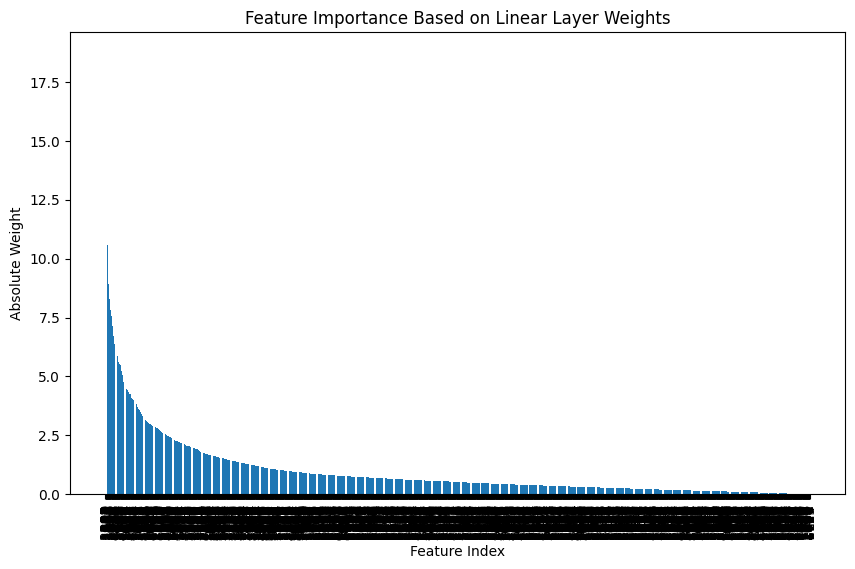

In [40]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [105]:
best_model.l1.weight.shape, "=>",9 * 305, "==",weights_np.shape, 305 //4

(torch.Size([9, 305]), '=>', 2745, '==', (305,), 76)

# Weight selected plots

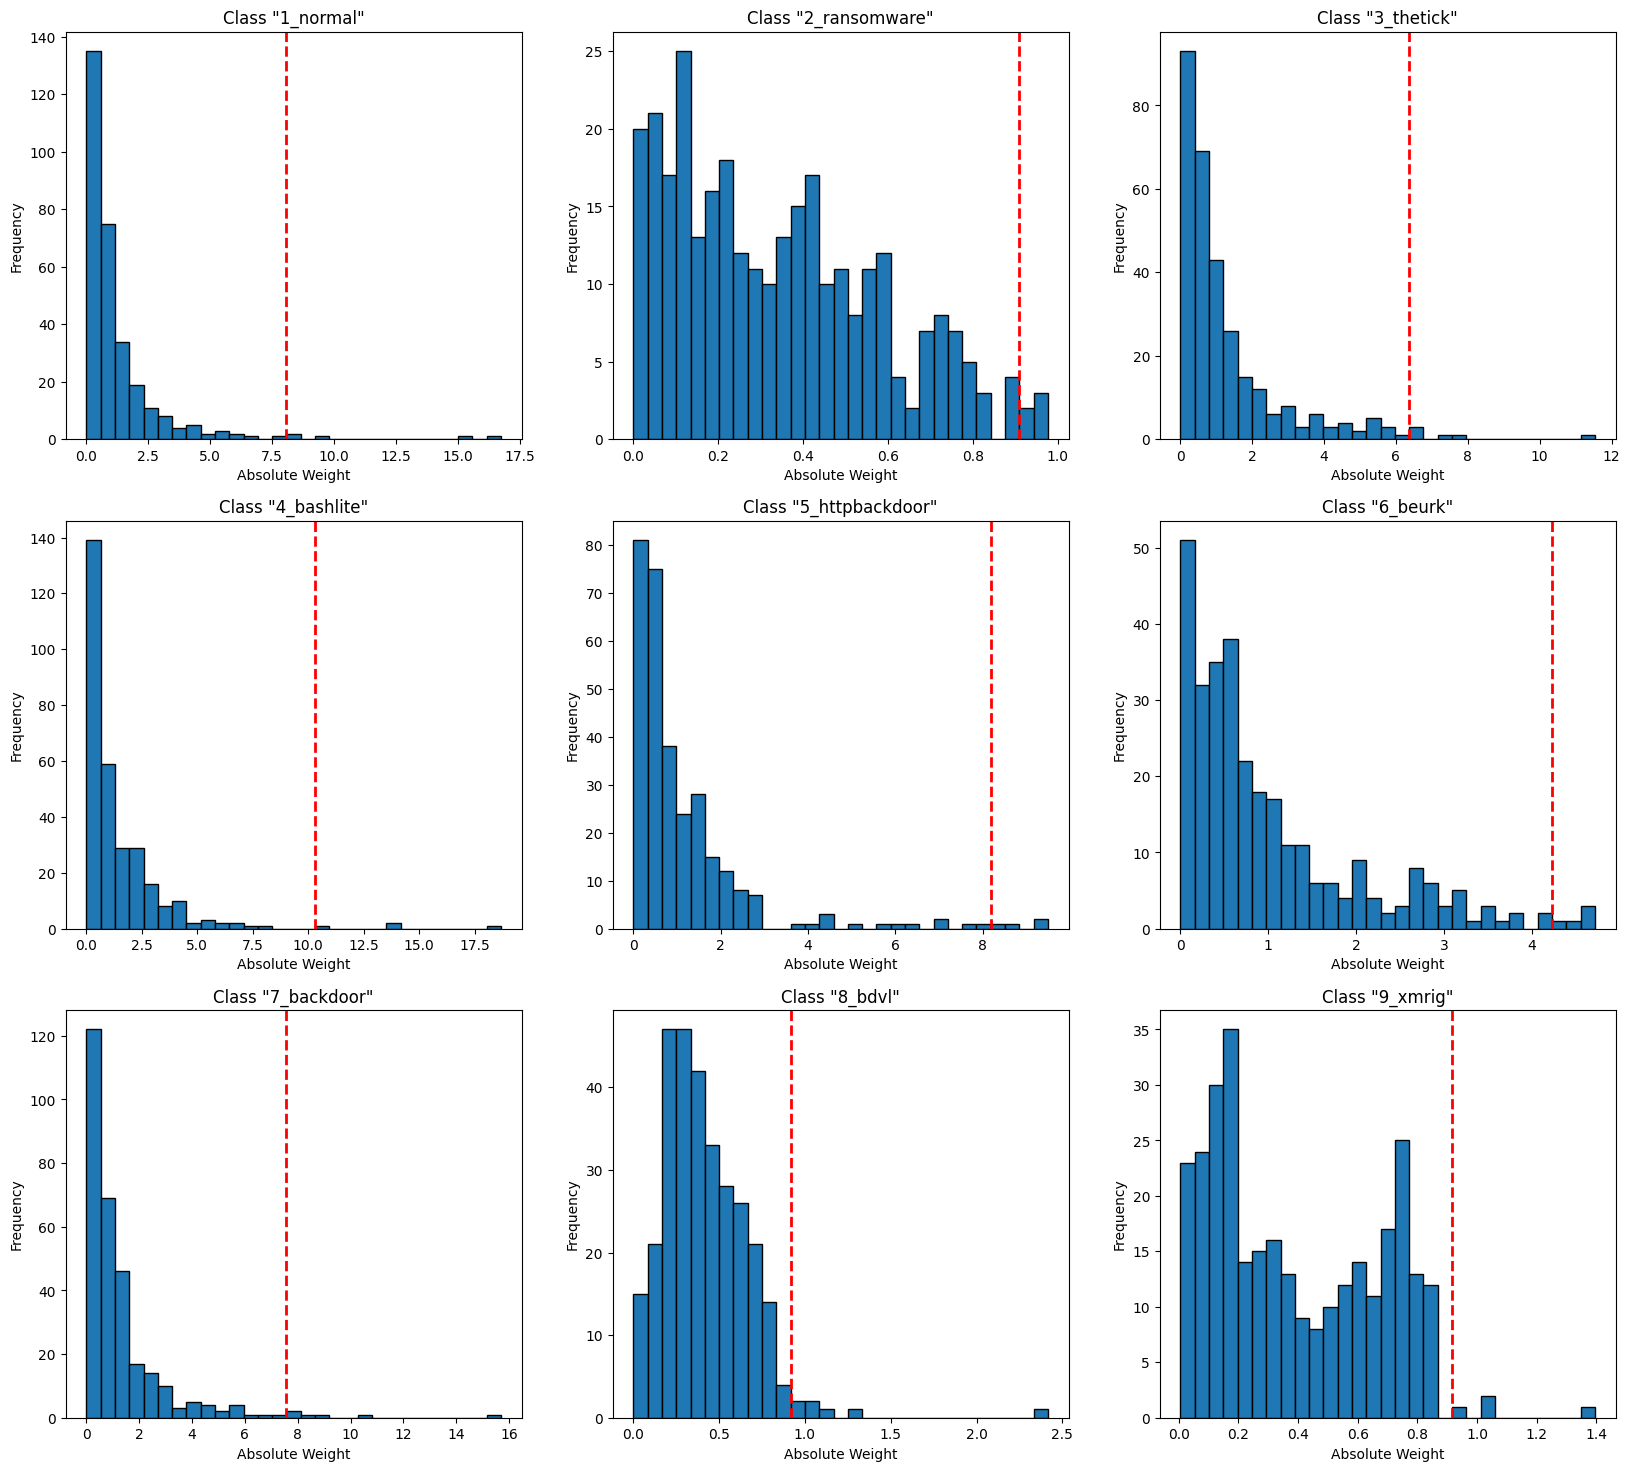

In [177]:
import matplotlib.pyplot as plt
import numpy as np

figcount_x = 3
figcount_y = 3
fig, axs = plt.subplots(figcount_y, figcount_x, figsize=(20, figcount_y * 6))

axs = axs.flatten()
for i in range(9):

    SELECTED_CLASS = i
    label = label_encoder.inverse_transform([SELECTED_CLASS])[0]

    # Convert to numpy array for easier manipulation
    weights_np = weights.numpy()[SELECTED_CLASS].flatten()
    abs_weights = np.abs(weights_np)
    abs_weights.sort()

    bins = np.linspace(abs_weights.min(), abs_weights.max(), 30)

    # Plot the histogram
    # plt.figure(figsize=(10, 6))
    axs[i].hist(abs_weights, bins=bins, edgecolor='black')

    # Get the bin edges and heights
    bin_edges = plt.xticks()[0]
    idx = np.argmin(np.abs(bins - abs_weights[-4])) -1
    threshold_bin_edge = bins[idx]

    # bin_heights, _,_ = plt.hist(abs_weights, bins=bins)

    # Find the x-coordinate of the 4th highest bin
    # top_4_bin_edges = np.sort(bin_edges)[-5:-1]
    # x_coord = top_4_bin_edges[-1]
    # x_coord = bins[-3]
    x_coord = threshold_bin_edge

    # Plot a red vertical line
    axs[i].axvline(x=x_coord, color='red', linestyle='--', linewidth=2)

    axs[i].set_xlabel('Absolute Weight')
    axs[i].set_ylabel('Frequency')
    # plt.yscale("log")
    axs[i].set_title(f'Class "{label}"')
plt.show()

In [76]:
weights.numpy()[0].shape

(305,)

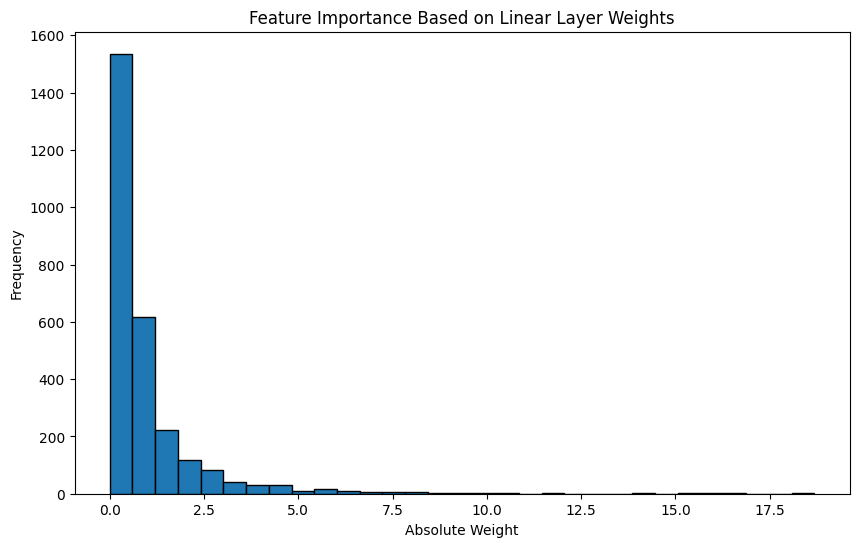

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Create 20 bins for the histogram
bins = np.linspace(abs_weights.min(), abs_weights.max(), 32)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(abs_weights, bins=bins, edgecolor='black')
plt.xlabel('Absolute Weight')
plt.ylabel('Frequency')
# plt.yscale("log")
plt.title('Feature Importance Based on Linear Layer Weights')
plt.show()

In [26]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

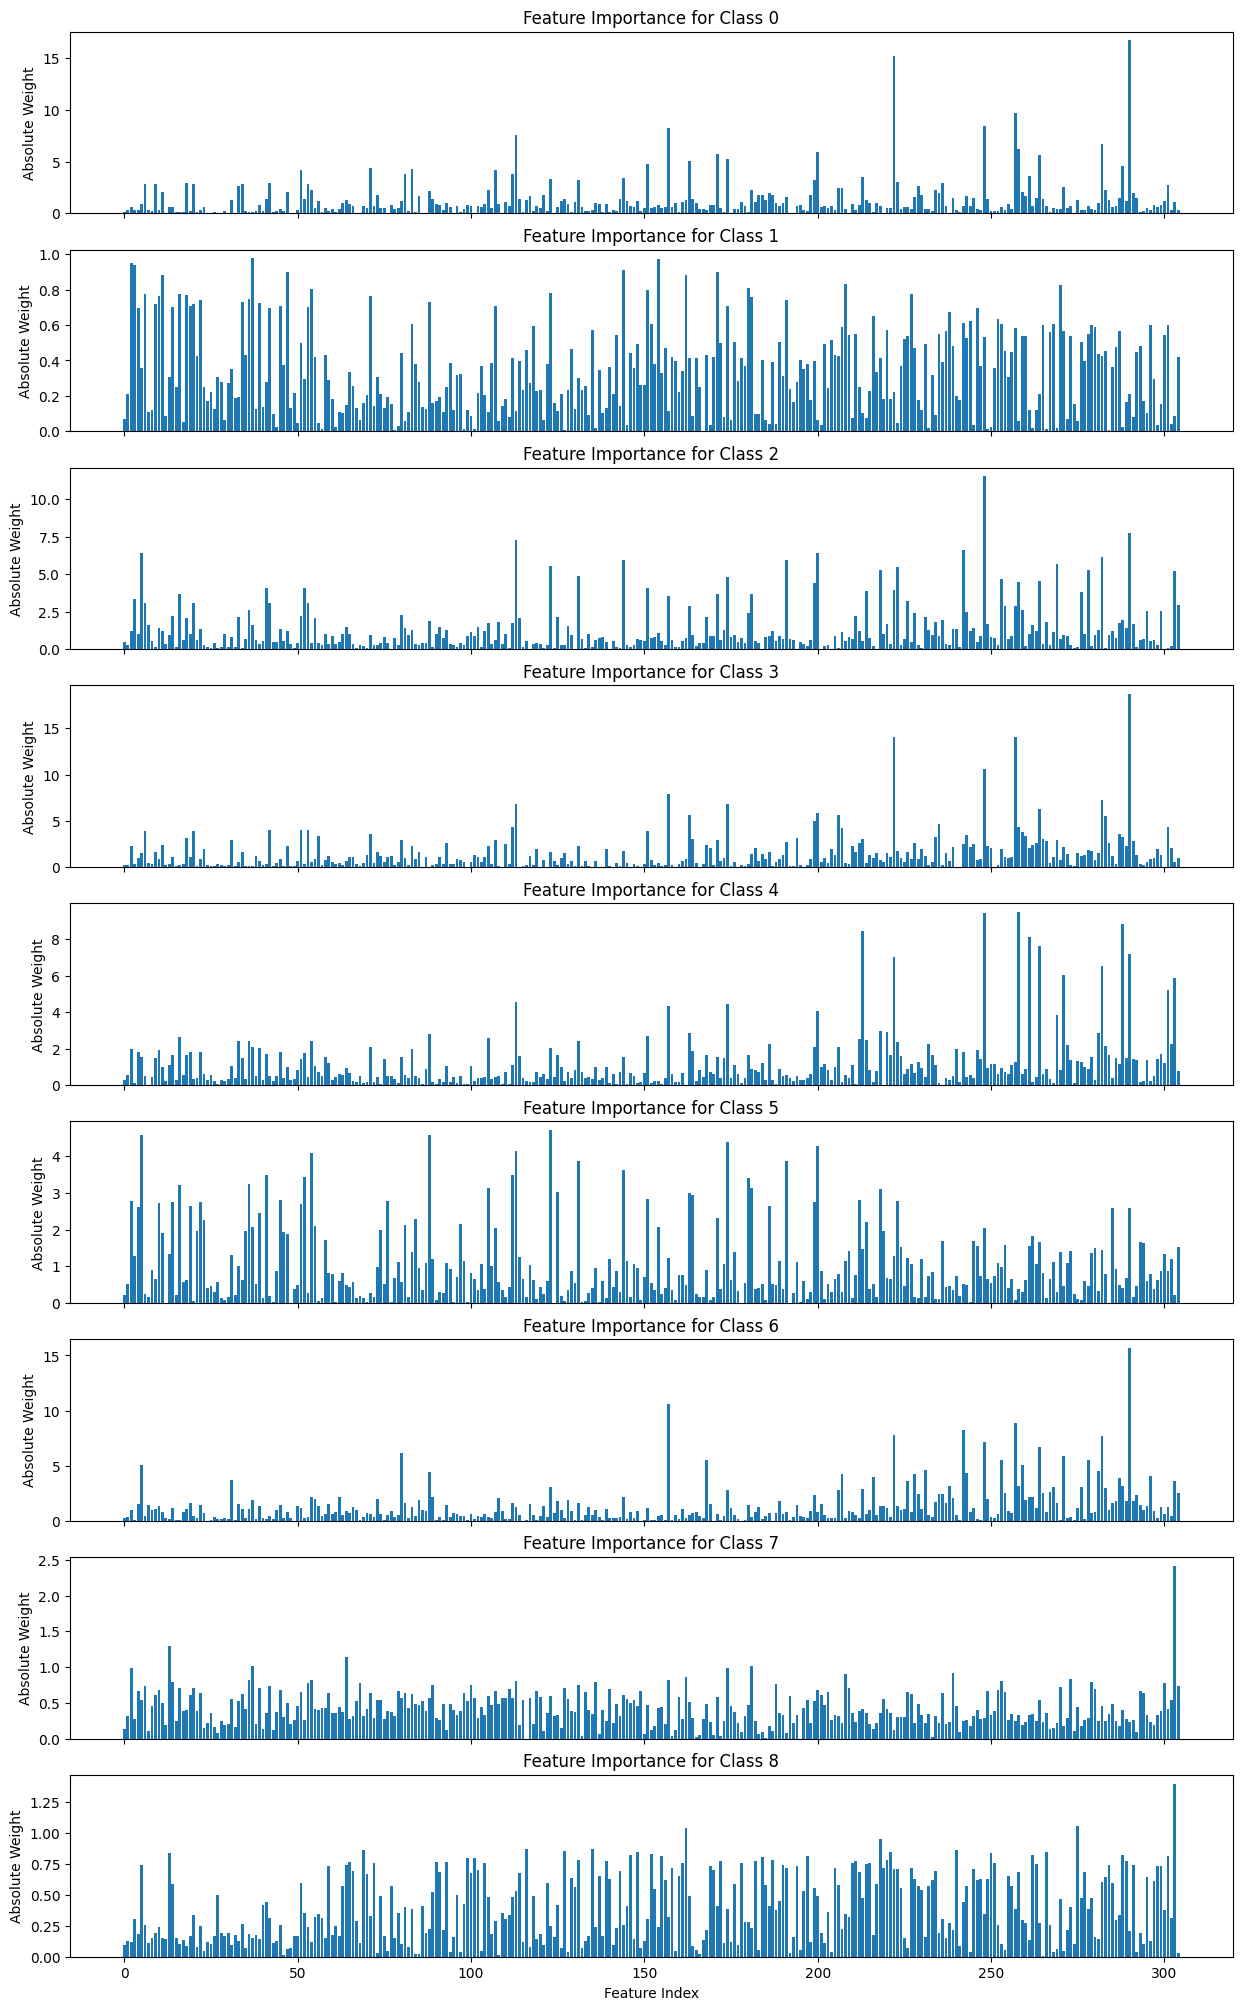

In [27]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [28]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [29]:
sorted_idx = weights_mean.argsort()[::-1]

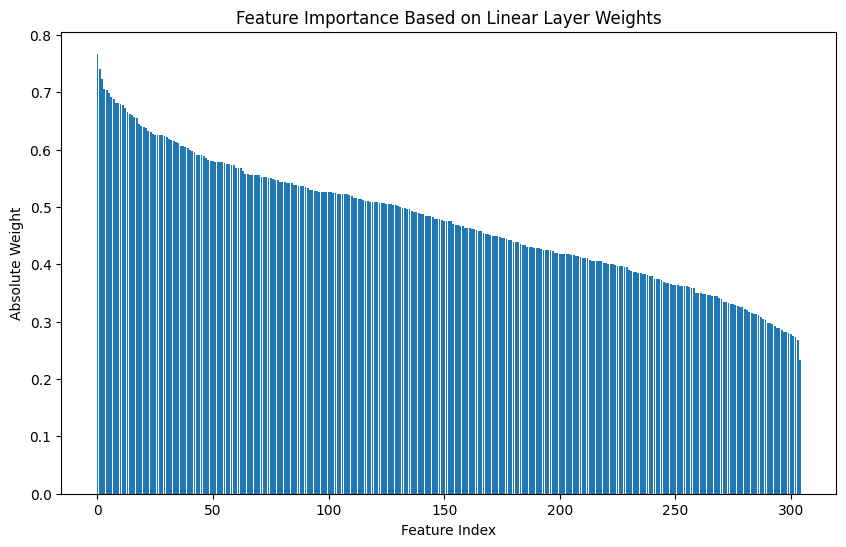

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

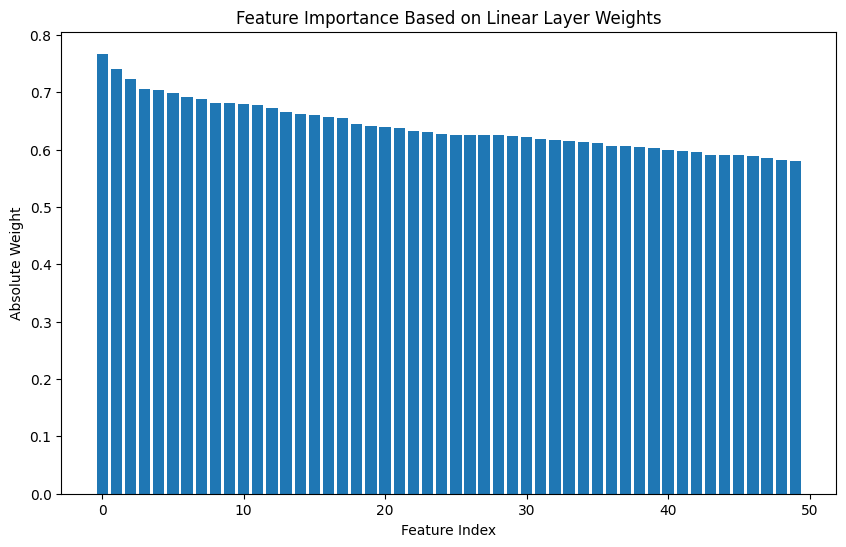

In [31]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [32]:
topk = 4

In [33]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [34]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [35]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(32,)

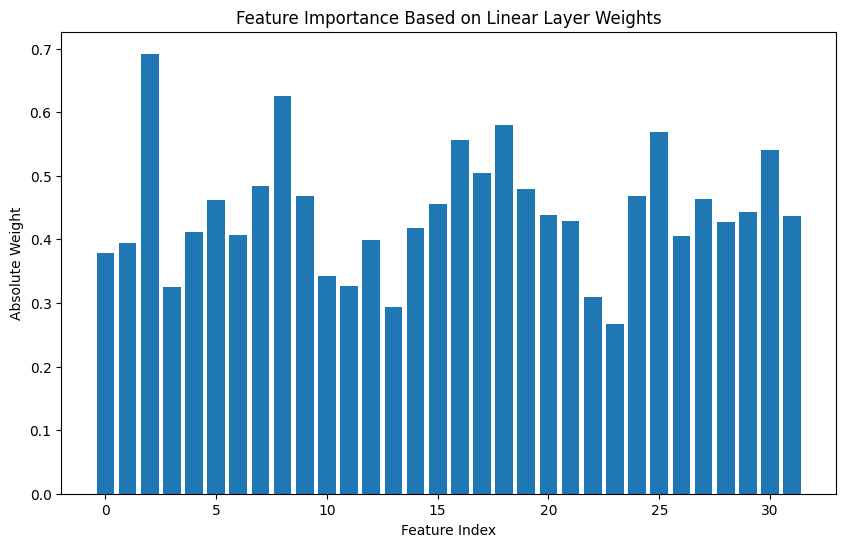

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [37]:
vectors.iloc[:,selected_features].shape

(25770, 32)

In [38]:
subset = vectors.iloc[:,selected_features]
subset["label"] = df["label"]

/tmp/ipykernel_7613/650136668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = df["label"]


In [40]:
# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_2)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 297   
------------------------------------------------------------
297       Trainable params
0         Non-trainable params
297       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0, 100,   4,   0,   0,   0,   0,   0,   0],
        [ 34,   0,  32,   0,   0,   0,  52,   0,   0],
        [  0,  99,  26,   0,   0,   0,   0,   0,   0],
        [  0, 107,   7,   0,   0,   0,   0,   0,   0],
        [  0,  83,  21,   0,   0,   0,   0,   0,   0],
        [  0,  50,  65,   0,   0,   0,   0,   0,   0],
        [  0,  92,  24,   0,   0,   0,   0,   0,   0],
        [  0,   1,  17,   0,  27,   0,  45,   0,   0],
        [  0, 111,   0,   0,   0,   3,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0, 1003,   32,    0,    0,    4,    0,    0, 1615],
        [  53, 3155,   54,    0,    0,    0,  136,    0,    0],
        [   0, 1700,  870,    0,    0,   58,    0,    0,  677],
        [   0, 1020,   55,    0,    0,    7,    0,    0, 1682],
        [   0, 1084,  102,    0,    0,    7,    0,    0, 1626],
        [   0, 1779,  119,    0,    0, 1018,    0,   19,    0],
        [   0, 1294,  437,    0,    0,   38,    0,    0,  997],
        [   0,  916,   34,    0,   65,    0,  107, 1613,    0],
        [   0,  551,    0,    0,    0,    6,    0,    0, 2837]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0, 1003,   32,    0,    0,    4,    0,    0, 1615],
        [  53, 3155,   54,    0,    0,    0,  136,    0,    0],
        [   0, 1700,  870,    0,    0,   58,    0,    0,  677],
        [   0, 1020,   55,    0,    0,    7,    0,    0, 1682],
        [   0, 1084,  102,    0,    0,    7,    0,    0, 16

Metric Validation/Accuracy improved. New best score: 0.518


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   1, 1004, 1083,    5,    8,   30,    0,    0, 3073],
        [  53, 6435,   54,    0,    0,    0,  136,    0,    0],
        [   0, 1700, 3822,    0,    5,   95,    0,    0,  863],
        [   0, 1021, 1001,   17,   30,   32,    0,    0, 3313],
        [   0, 1084,  645,    0,  845,   51,    0,    0, 2909],
        [   0, 1787,  405,    0,    0, 3531,    0,   32,    0],
        [   0, 1294, 2464,    0,    7,  104,    0,    0, 1547],
        [   0,  916,   34,    0,   65,    0,  107, 4258,    0],
        [   0,  551,    4,    0,    0,    6,    0,    0, 6113]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   1, 1004, 1083,    5,    8,   30,    0,    0, 3073],
        [  53, 6435,   54,    0,    0,    0,  136,    0,    0],
        [   0, 1700, 3822,    0,    5,   95,    0,    0,  863],
        [   0, 1021, 1001,   17,   30,   32,    0,    0, 3313],
        [   0, 1084,  645,    0,  845,   51,    0,    0, 29

Metric Validation/Accuracy improved by 0.105 >= min_delta = 0.0. New best score: 0.624


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 563, 1004, 2058,  468,   53,   65,    0,    0, 3543],
        [  53, 9710,   54,    0,    0,    5,  136,    0,    0],
        [   0, 1700, 6945,    0,   17,  119,    0,    0,  884],
        [   4, 1021, 2137,  753,  149,   57,    0,    0, 3943],
        [   1, 1084,  883,    6, 3095,  102,    0,    0, 3078],
        [   0, 1788,  744,    0,    0, 6008,    0,   35,    0],
        [   4, 1294, 4794,   59,   57,  169,    0,    0, 1689],
        [   0,  916,   34,    0,   65,    0,  107, 6903,    0],
        [   0,  551,    8,    1,    0,    6,    0,    0, 9388]])


Metric Validation/Accuracy improved by 0.066 >= min_delta = 0.0. New best score: 0.690


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 563, 1004, 2058,  468,   53,   65,    0,    0, 3543],
        [  53, 9710,   54,    0,    0,    5,  136,    0,    0],
        [   0, 1700, 6945,    0,   17,  119,    0,    0,  884],
        [   4, 1021, 2137,  753,  149,   57,    0,    0, 3943],
        [   1, 1084,  883,    6, 3095,  102,    0,    0, 3078],
        [   0, 1788,  744,    0,    0, 6008,    0,   35,    0],
        [   4, 1294, 4794,   59,   57,  169,    0,    0, 1689],
        [   0,  916,   34,    0,   65,    0,  107, 6903,    0],
        [   0,  551,    8,    1,    0,    6,    0,    0, 9388]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 1320,  1004,  2424,  1612,   187,   100,     0,     0,  3657],
        [   53, 12985,    54,     0,     0,    10,   136,     0,     0],
        [    0,  1700, 10067,     9,    41,   143,     0,     0,   885],
        [    9,  1021,  2641,  2449,   465,    82,     0,     0,  4047],
        [    5,  1084,   944,    19,  5673,   156,     0,     0,  3083],
        [    0,  1788,  1204,     0,     0,  8368,     0,    35,     0],
        [    4,  1294,  6913,   284,   261,   234,     4,     0,  1722],
        [    0,   916,    34,     0,    65,     0,   107,  9548,     0],
        [    0,   551,     8,     6,     0,     6,     0,     0, 12663]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 1320,  1004,  2424,  1612,   187,   100,     0,     0,  3657],
        [   53, 12985,    54,     0,     0,    10,   136,     0,     0],
        [    0,  1700, 10067,     9,    41,   143,     0,     0,   885],
        [    9,

Metric Validation/Accuracy improved by 0.093 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 2802,  1004,  2502,  2519,   199,   135,     0,     0,  3693],
        [   53, 16260,    54,     0,     0,    15,   136,     0,     0],
        [    0,  1700, 13156,    46,    71,   167,     0,     0,   885],
        [   40,  1021,  2812,  4637,   682,   107,     0,     0,  4065],
        [   10,  1084,   974,    50,  8269,   209,     0,     0,  3083],
        [    0,  1788,  1687,     0,     0, 10705,     0,    35,     0],
        [    5,  1294,  8782,   762,   478,   301,     7,     0,  1737],
        [    0,   916,    34,     0,    65,     5,   107, 12188,     0],
        [    0,   551,     8,    14,     0,     6,     0,     0, 15935]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.783


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 2802,  1004,  2502,  2519,   199,   135,     0,     0,  3693],
        [   53, 16260,    54,     0,     0,    15,   136,     0,     0],
        [    0,  1700, 13156,    46,    71,   167,     0,     0,   885],
        [   40,  1021,  2812,  4637,   682,   107,     0,     0,  4065],
        [   10,  1084,   974,    50,  8269,   209,     0,     0,  3083],
        [    0,  1788,  1687,     0,     0, 10705,     0,    35,     0],
        [    5,  1294,  8782,   762,   478,   301,     7,     0,  1737],
        [    0,   916,    34,     0,    65,     5,   107, 12188,     0],
        [    0,   551,     8,    14,     0,     6,     0,     0, 15935]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 4591,  1004,  2550,  3155,   215,   170,     1,     0,  3718],
        [   53, 19535,    54,     0,     0,    20,   136,     0,     0],
        [    0,  1700, 16232,    78,   119,   191,     0,     0,   885],
        [   91,  1021,  2939,  6734,  1013,   132,    12,     0,  4072],
        [   15,  1084,   993,    61, 10908,   250,     0,     0,  3083],
        [    0,  1788,  2265,     0,     0, 12947,     0,    35,     0],
        [   11,  1294, 10605,  1200,   776,   366,    23,     0,  1741],
        [    0,   916,    34,     0,    65,    11,   107, 14827,     0],
        [    0,   551,     8,    23,     0,     6,     0,     0, 19206]])


Metric Validation/Accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.804


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 4591,  1004,  2550,  3155,   215,   170,     1,     0,  3718],
        [   53, 19535,    54,     0,     0,    20,   136,     0,     0],
        [    0,  1700, 16232,    78,   119,   191,     0,     0,   885],
        [   91,  1021,  2939,  6734,  1013,   132,    12,     0,  4072],
        [   15,  1084,   993,    61, 10908,   250,     0,     0,  3083],
        [    0,  1788,  2265,     0,     0, 12947,     0,    35,     0],
        [   11,  1294, 10605,  1200,   776,   366,    23,     0,  1741],
        [    0,   916,    34,     0,    65,    11,   107, 14827,     0],
        [    0,   551,     8,    23,     0,     6,     0,     0, 19206]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 6496,  1004,  2571,  3724,   225,   205,     1,     0,  3728],
        [   53, 22810,    54,     0,     0,    25,   136,     0,     0],
        [    0,  1700, 19290,   140,   155,   215,     0,     0,   885],
        [  179,  1021,  3013,  9009,  1200,   157,    12,     0,  4073],
        [   20,  1084,  1008,    89, 13540,   285,     0,     0,  3083],
        [    0,  1788,  2763,     0,     0, 15269,     0,    35,     0],
        [   26,  1294, 12308,  1806,  1027,   431,    33,     0,  1741],
        [    0,   916,    34,     0,    65,    16,   107, 17467,     0],
        [    0,   551,     8,    33,     0,     6,     0,     0, 22476]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 6496,  1004,  2571,  3724,   225,   205,     1,     0,  3728],
        [   53, 22810,    54,     0,     0,    25,   136,     0,     0],
        [    0,  1700, 19290,   140,   155,   215,     0,     0,   885],
        [  179,

Metric Validation/Accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 8634,  1004,  2595,  4059,   236,   240,     1,     0,  3735],
        [   53, 26085,    54,     0,     0,    30,   136,     0,     0],
        [    0,  1700, 22360,   175,   206,   239,     0,     0,   885],
        [  333,  1021,  3104, 11096,  1485,   182,    20,     0,  4073],
        [   25,  1084,  1018,    94, 16213,   307,     0,     0,  3083],
        [    0,  1788,  3281,     0,     0, 17571,     0,    35,     0],
        [   54,  1294, 14042,  2267,  1345,   496,    77,     0,  1741],
        [    0,   916,    34,     0,    65,    21,   107, 20107,     0],
        [    0,   551,     8,    43,     0,     6,     0,     0, 25746]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 8634,  1004,  2595,  4059,   236,   240,     1,     0,  3735],
        [   53, 26085,    54,     0,     0,    30,   136,     0,     0],
        [    0,  1700, 22360,   175,   206,   239,     0,     0,   885],
        [  333,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[10702,  1004,  2611,  4476,   246,   274,     1,     0,  3740],
        [   53, 29360,    54,     0,     0,    35,   136,     0,     0],
        [    4,  1700, 25404,   237,   252,   263,     0,     0,   885],
        [  485,  1021,  3155, 13321,  1667,   207,    35,     0,  4073],
        [   32,  1084,  1030,   119, 18864,   327,     0,     0,  3083],
        [    0,  1788,  3810,     0,     0, 19862,     0,    35,     0],
        [   86,  1294, 15649,  2871,  1600,   562,   163,     0,  1741],
        [    0,   916,    34,     0,    65,    26,   107, 22747,     0],
        [    0,   551,     8,    53,     0,     6,     0,     0, 29016]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[10702,  1004,  2611,  4476,   246,   274,     1,     0,  3740],
        [   53, 29360,    54,     0,     0,    35,   136,     0,     0],
        [    4,  1700, 25404,   237,   252,   263,     0,     0,   885],
        [  485,

Metric Validation/Accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.840


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[12860,  1004,  2611,  4823,   256,   304,     1,     0,  3745],
        [   53, 32635,    54,     0,     0,    40,   136,     0,     0],
        [    4,  1700, 28427,   317,   305,   287,     0,     0,   885],
        [  685,  1021,  3173, 15570,  1804,   229,    59,     0,  4073],
        [   38,  1084,  1040,   142, 21521,   346,     0,     0,  3083],
        [    0,  1788,  4231,     0,     0, 22261,     0,    35,     0],
        [  140,  1294, 17140,  3519,  1847,   627,   308,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 25388,     0],
        [    0,   551,     8,    63,     0,     6,     0,     0, 32286]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[12860,  1004,  2611,  4823,   256,   304,     1,     0,  3745],
        [   53, 32635,    54,     0,     0,    40,   136,     0,     0],
        [    4,  1700, 28427,   317,   305,   287,     0,     0,   885],
        [  685

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[15095,  1004,  2611,  5094,   268,   328,     4,     0,  3750],
        [   53, 35910,    54,     0,     0,    45,   136,     0,     0],
        [    7,  1700, 31469,   380,   353,   311,     0,     0,   885],
        [  930,  1021,  3193, 17758,  1943,   249,    97,     0,  4073],
        [   44,  1084,  1050,   155, 24192,   361,     0,     0,  3083],
        [    0,  1788,  4618,     0,     0, 24694,     0,    35,     0],
        [  204,  1294, 18596,  4105,  2104,   692,   530,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 28033,     0],
        [    0,   551,     8,    73,     0,     6,     0,     0, 35556]])
Epoch end: Train, epoch number: 10


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.847


TrainEpoch/CM
 tensor([[15095,  1004,  2611,  5094,   268,   328,     4,     0,  3750],
        [   53, 35910,    54,     0,     0,    45,   136,     0,     0],
        [    7,  1700, 31469,   380,   353,   311,     0,     0,   885],
        [  930,  1021,  3193, 17758,  1943,   249,    97,     0,  4073],
        [   44,  1084,  1050,   155, 24192,   361,     0,     0,  3083],
        [    0,  1788,  4618,     0,     0, 24694,     0,    35,     0],
        [  204,  1294, 18596,  4105,  2104,   692,   530,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 28033,     0],
        [    0,   551,     8,    73,     0,     6,     0,     0, 35556]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[17367,  1004,  2611,  5341,   283,   339,     4,     0,  3755],
        [   53, 39185,    54,     0,     0,    50,   136,     0,     0],
        [   14,  1700, 34479,   463,   398,   335,    11,     0,   885],
        [ 1174,  1021,  3205, 19967,  2072,   269,   133,     0,  4073],
        [   49,  1084,  1058,   178, 26866,   366,     0,     0,  3083],
        [    0,  1788,  4989,     0,     0, 27143,     0,    35,     0],
        [  271,  1294, 20020,  4722,  2347,   757,   764,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 30678,     0],
        [    0,   551,     8,    83,     0,     6,     0,     0, 38826]])
Epoch end: Train, epoch number: 11


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.850


TrainEpoch/CM
 tensor([[17367,  1004,  2611,  5341,   283,   339,     4,     0,  3755],
        [   53, 39185,    54,     0,     0,    50,   136,     0,     0],
        [   14,  1700, 34479,   463,   398,   335,    11,     0,   885],
        [ 1174,  1021,  3205, 19967,  2072,   269,   133,     0,  4073],
        [   49,  1084,  1058,   178, 26866,   366,     0,     0,  3083],
        [    0,  1788,  4989,     0,     0, 27143,     0,    35,     0],
        [  271,  1294, 20020,  4722,  2347,   757,   764,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 30678,     0],
        [    0,   551,     8,    83,     0,     6,     0,     0, 38826]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[19637,  1004,  2611,  5584,   298,   349,    11,     0,  3760],
        [   53, 42460,    54,     0,     0,    55,   136,     0,     0],
        [   22,  1700, 37463,   543,   438,   359,    55,     0,   885],
        [ 1400,  1021,  3218, 22183,  2195,   289,   185,     0,  4073],
        [   54,  1084,  1066,   200, 29541,   371,     0,     0,  3083],
        [    0,  1788,  5300,     0,     0, 29652,     0,    35,     0],
        [  343,  1294, 21420,  5340,  2575,   822,  1031,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 33323,     0],
        [    0,   551,     8,    93,     0,     6,     0,     0, 42096]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[19637,  1004,  2611,  5584,   298,   349,    11,     0,  3760],
        [   53, 42460,    54,     0,     0,    55,   136,     0,     0],
        [   22,  1700, 37463,   543,   438,   359,    55,     0,   885],
        [ 140

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.854


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[21974,  1004,  2611,  5769,   310,   359,    12,     0,  3765],
        [   53, 45735,    54,     0,     0,    60,   136,     0,     0],
        [   31,  1700, 40465,   624,   470,   383,    87,     0,   885],
        [ 1679,  1021,  3232, 24345,  2322,   309,   233,     0,  4073],
        [   60,  1084,  1076,   219, 32216,   376,     0,     0,  3083],
        [    0,  1788,  5555,     0,     0, 32217,     0,    35,     0],
        [  430,  1294, 22786,  5917,  2800,   887,  1361,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 35968,     0],
        [    0,   551,     8,   103,     0,     6,     0,     0, 45366]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[21974,  1004,  2611,  5769,   310,   359,    12,     0,  3765],
        [   53, 45735,    54,     0,     0,    60,   136,     0,     0],
        [   31,  1700, 40465,   624,   470,   383,    87,     0,   885],
        [ 167

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[24295,  1004,  2611,  5970,   322,   369,    13,     0,  3770],
        [   53, 49010,    54,     0,     0,    65,   136,     0,     0],
        [   38,  1700, 43425,   712,   503,   407,   155,     0,   885],
        [ 1955,  1021,  3242, 26528,  2436,   326,   283,     0,  4073],
        [   66,  1084,  1085,   245, 34885,   381,     0,     0,  3083],
        [    0,  1788,  5765,     0,     0, 34827,     0,    35,     0],
        [  513,  1294, 24073,  6525,  3015,   954,  1751,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 38613,     0],
        [    0,   551,     8,   113,     0,     6,     0,     0, 48636]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[24295,  1004,  2611,  5970,   322,   369,    13,     0,  3770],
        [   53, 49010,    54,     0,     0,    65,   136,     0,     0],
        [   38,  1700, 43425,   712,   503,   407,   155,     0,   885],
        [ 195

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[26643,  1004,  2611,  6147,   335,   379,    15,     0,  3770],
        [   53, 52285,    54,     0,     0,    70,   136,     0,     0],
        [   47,  1700, 46409,   788,   535,   431,   210,     0,   885],
        [ 2237,  1021,  3256, 28703,  2545,   345,   334,     0,  4073],
        [   71,  1084,  1095,   270, 37555,   386,     0,     0,  3083],
        [    0,  1788,  5987,     0,     0, 37425,     0,    35,     0],
        [  603,  1294, 25404,  7116,  3225,  1021,  2112,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 41258,     0],
        [    0,   551,     8,   123,     0,     6,     0,     0, 51906]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.864


Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[26643,  1004,  2611,  6147,   335,   379,    15,     0,  3770],
        [   53, 52285,    54,     0,     0,    70,   136,     0,     0],
        [   47,  1700, 46409,   788,   535,   431,   210,     0,   885],
        [ 2237,  1021,  3256, 28703,  2545,   345,   334,     0,  4073],
        [   71,  1084,  1095,   270, 37555,   386,     0,     0,  3083],
        [    0,  1788,  5987,     0,     0, 37425,     0,    35,     0],
        [  603,  1294, 25404,  7116,  3225,  1021,  2112,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 41258,     0],
        [    0,   551,     8,   123,     0,     6,     0,     0, 51906]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[29029,  1004,  2611,  6301,   339,   385,    15,     0,  3770],
        [   53, 55560,    54,     0,     0,    75,   136,     0,     0],
        [   54,  1700, 49369,   871,   564,   455,   287,     0,   885],
        [ 2532,  1021,  3266, 30860,  2656,   359,   397,     0,  4073],
        [   77,  1084,  1105,   296, 40223,   391,     0,     0,  3083],
        [    0,  1788,  6181,     0,     0, 40051,     0,    35,     0],
        [  706,  1294, 26658,  7697,  3418,  1088,  2564,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 43903,     0],
        [    0,   551,     8,   133,     0,     6,     0,     0, 55176]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.871


Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[29029,  1004,  2611,  6301,   339,   385,    15,     0,  3770],
        [   53, 55560,    54,     0,     0,    75,   136,     0,     0],
        [   54,  1700, 49369,   871,   564,   455,   287,     0,   885],
        [ 2532,  1021,  3266, 30860,  2656,   359,   397,     0,  4073],
        [   77,  1084,  1105,   296, 40223,   391,     0,     0,  3083],
        [    0,  1788,  6181,     0,     0, 40051,     0,    35,     0],
        [  706,  1294, 26658,  7697,  3418,  1088,  2564,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 43903,     0],
        [    0,   551,     8,   133,     0,     6,     0,     0, 55176]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[31392,  1004,  2611,  6473,   347,   390,    17,     0,  3770],
        [   53, 58835,    54,     0,     0,    80,   136,     0,     0],
        [   65,  1700, 52298,   955,   593,   479,   390,     0,   885],
        [ 2781,  1021,  3273, 33071,  2770,   369,   456,     0,  4073],
        [   82,  1084,  1115,   323, 42891,   396,     0,     0,  3083],
        [    0,  1788,  6340,     0,     0, 42712,     0,    35,     0],
        [  787,  1294, 27877,  8295,  3620,  1158,  3044,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 46548,     0],
        [    0,   551,     8,   143,     0,     6,     0,     0, 58446]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[31392,  1004,  2611,  6473,   347,   390,    17,     0,  3770],
        [   53, 58835,    54,     0,     0,    80,   136,     0,     0],
        [   65,  1700, 52298,   955,   593,   479,   390,     0,   885],
        [ 278

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[33814,  1004,  2611,  6595,   347,   395,    18,     0,  3770],
        [   53, 62110,    54,     0,     0,    85,   136,     0,     0],
        [   74,  1700, 55226,  1036,   620,   503,   501,     0,   885],
        [ 3088,  1021,  3283, 35223,  2876,   379,   521,     0,  4073],
        [   87,  1084,  1125,   347, 45562,   401,     0,     0,  3083],
        [    0,  1788,  6497,     0,     0, 45375,     0,    35,     0],
        [  902,  1294, 29072,  8848,  3799,  1228,  3582,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 49193,     0],
        [    0,   551,     8,   153,     0,     6,     0,     0, 61716]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[33814,  1004,  2611,  6595,   347,   395,    18,     0,  3770],
        [   53, 62110,    54,     0,     0,    85,   136,     0,     0],
        [   74,  1700, 55226,  1036,   620,   503,   501,     0,   885],
        [ 308

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[36240,  1004,  2611,  6712,   348,   400,    19,     0,  3770],
        [   53, 65385,    54,     0,     0,    90,   136,     0,     0],
        [   86,  1700, 58147,  1116,   648,   527,   616,     0,   885],
        [ 3412,  1021,  3293, 37355,  2984,   384,   592,     0,  4073],
        [   92,  1084,  1135,   370, 48234,   406,     0,     0,  3083],
        [    0,  1788,  6646,     0,     0, 48046,     0,    35,     0],
        [ 1021,  1294, 30251,  9382,  3991,  1298,  4138,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 51838,     0],
        [    0,   551,     8,   163,     0,     6,     0,     0, 64986]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[36240,  1004,  2611,  6712,   348,   400,    19,     0,  3770],
        [   53, 65385,    54,     0,     0,    90,   136,     0,     0],
        [   86,  1700, 58147,  1116,   648,   527,   616,     0,   885],
        [ 341

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[38664,  1004,  2611,  6833,   348,   405,    19,     0,  3770],
        [   53, 68660,    54,     0,     0,    95,   136,     0,     0],
        [   98,  1700, 61067,  1200,   672,   551,   732,     0,   885],
        [ 3726,  1021,  3303, 39508,  3084,   389,   660,     0,  4073],
        [   97,  1084,  1147,   397, 50900,   411,     0,     0,  3083],
        [    0,  1788,  6798,     0,     0, 50714,     0,    35,     0],
        [ 1142,  1294, 31428,  9939,  4165,  1368,  4689,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 54483,     0],
        [    0,   551,     8,   173,     0,     6,     0,     0, 68256]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[38664,  1004,  2611,  6833,   348,   405,    19,     0,  3770],
        [   53, 68660,    54,     0,     0,    95,   136,     0,     0],
        [   98,  1700, 61067,  1200,   672,   551,   732,     0,   885],
        [ 372

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[41080,  1004,  2611,  6962,   348,   410,    19,     0,  3770],
        [   53, 71935,    54,     0,     0,   100,   136,     0,     0],
        [  109,  1700, 63973,  1289,   696,   572,   861,     0,   885],
        [ 3999,  1021,  3312, 41695,  3186,   394,   734,     0,  4073],
        [  102,  1084,  1161,   424, 53564,   416,     0,     0,  3083],
        [    0,  1788,  6924,     0,     0, 53408,     0,    35,     0],
        [ 1239,  1294, 32550, 10518,  4331,  1436,  5307,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 57128,     0],
        [    0,   551,     8,   182,     0,     6,     1,     0, 71526]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[41080,  1004,  2611,  6962,   348,   410,    19,     0,  3770],
        [   53, 71935,    54,     0,     0,   100,   136,     0,     0],
        [  109,  1700, 63973,  1289,   696,   572,   861,     0,   885],
        [ 399

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[43512,  1004,  2611,  7075,   348,   415,    19,     0,  3770],
        [   53, 75210,    54,     0,     0,   105,   136,     0,     0],
        [  121,  1700, 66898,  1370,   723,   588,   980,     0,   885],
        [ 4292,  1021,  3322, 43873,  3279,   399,   805,     0,  4073],
        [  107,  1084,  1172,   451, 56231,   421,     0,     0,  3083],
        [    0,  1788,  7060,     0,     0, 56092,     0,    35,     0],
        [ 1354,  1294, 33711, 11067,  4503,  1501,  5895,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 59773,     0],
        [    0,   551,     8,   192,     0,     6,     1,     0, 74796]])
Epoch end: Train, epoch number: 22


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.880


TrainEpoch/CM
 tensor([[43512,  1004,  2611,  7075,   348,   415,    19,     0,  3770],
        [   53, 75210,    54,     0,     0,   105,   136,     0,     0],
        [  121,  1700, 66898,  1370,   723,   588,   980,     0,   885],
        [ 4292,  1021,  3322, 43873,  3279,   399,   805,     0,  4073],
        [  107,  1084,  1172,   451, 56231,   421,     0,     0,  3083],
        [    0,  1788,  7060,     0,     0, 56092,     0,    35,     0],
        [ 1354,  1294, 33711, 11067,  4503,  1501,  5895,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 59773,     0],
        [    0,   551,     8,   192,     0,     6,     1,     0, 74796]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[45956,  1004,  2611,  7176,   348,   420,    19,     0,  3770],
        [   53, 78485,    54,     0,     0,   110,   136,     0,     0],
        [  130,  1700, 69785,  1454,   747,   600,  1144,     0,   885],
        [ 4598,  1021,  3332, 46021,  3371,   404,   894,     0,  4073],
        [  112,  1084,  1186,   473, 58900,   426,     0,     0,  3083],
        [    0,  1788,  7168,     0,     0, 58804,     0,    35,     0],
        [ 1465,  1294, 34781, 11581,  4663,  1566,  6625,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 62418,     0],
        [    0,   551,     8,   198,     0,     6,     5,     0, 78066]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[45956,  1004,  2611,  7176,   348,   420,    19,     0,  3770],
        [   53, 78485,    54,     0,     0,   110,   136,     0,     0],
        [  130,  1700, 69785,  1454,   747,   600,  1144,     0,   885],
        [ 459

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[48378,  1004,  2611,  7299,   348,   425,    19,     0,  3770],
        [   53, 81760,    54,     0,     0,   115,   136,     0,     0],
        [  142,  1700, 72691,  1541,   771,   612,  1283,     0,   885],
        [ 4866,  1021,  3340, 48240,  3457,   406,   961,     0,  4073],
        [  117,  1084,  1198,   504, 61562,   431,     0,     0,  3083],
        [    0,  1788,  7278,     0,     0, 61514,     0,    35,     0],
        [ 1554,  1294, 35894, 12167,  4816,  1631,  7269,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 65063,     0],
        [    0,   551,     8,   208,     0,     6,     5,     0, 81336]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[48378,  1004,  2611,  7299,   348,   425,    19,     0,  3770],
        [   53, 81760,    54,     0,     0,   115,   136,     0,     0],
        [  142,  1700, 72691,  1541,   771,   612,  1283,     0,   885],
        [ 486

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[50816,  1004,  2611,  7406,   348,   430,    19,     0,  3770],
        [   53, 85035,    54,     0,     0,   120,   136,     0,     0],
        [  151,  1700, 75578,  1625,   795,   624,  1447,     0,   885],
        [ 5135,  1021,  3348, 50435,  3546,   406,  1050,     0,  4073],
        [  122,  1084,  1213,   527, 64229,   436,     0,     0,  3083],
        [    0,  1788,  7381,     0,     0, 64231,     0,    35,     0],
        [ 1648,  1294, 36975, 12711,  4968,  1690,  7989,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 67708,     0],
        [    0,   551,     8,   216,     0,     6,     7,     0, 84606]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[50816,  1004,  2611,  7406,   348,   430,    19,     0,  3770],
        [   53, 85035,    54,     0,     0,   120,   136,     0,     0],
        [  151,  1700, 75578,  1625,   795,   624,  1447,     0,   885],
        [ 513

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[53258,  1004,  2611,  7511,   348,   432,    20,     0,  3770],
        [   53, 88310,    54,     0,     0,   125,   136,     0,     0],
        [  162,  1700, 78465,  1709,   819,   636,  1609,     0,   885],
        [ 5415,  1021,  3356, 52617,  3632,   406,  1144,     0,  4073],
        [  127,  1084,  1228,   552, 66894,   441,     0,     0,  3083],
        [    0,  1788,  7479,     0,     0, 66953,     0,    35,     0],
        [ 1746,  1294, 38028, 13228,  5117,  1740,  8772,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 70353,     0],
        [    0,   551,     8,   224,     0,     6,     9,     0, 87876]])
Epoch end: Train, epoch number: 26


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.882


TrainEpoch/CM
 tensor([[53258,  1004,  2611,  7511,   348,   432,    20,     0,  3770],
        [   53, 88310,    54,     0,     0,   125,   136,     0,     0],
        [  162,  1700, 78465,  1709,   819,   636,  1609,     0,   885],
        [ 5415,  1021,  3356, 52617,  3632,   406,  1144,     0,  4073],
        [  127,  1084,  1228,   552, 66894,   441,     0,     0,  3083],
        [    0,  1788,  7479,     0,     0, 66953,     0,    35,     0],
        [ 1746,  1294, 38028, 13228,  5117,  1740,  8772,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 70353,     0],
        [    0,   551,     8,   224,     0,     6,     9,     0, 87876]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[55700,  1004,  2611,  7619,   348,   432,    20,     0,  3770],
        [   53, 91585,    54,     0,     0,   130,   136,     0,     0],
        [  172,  1700, 81351,  1793,   843,   649,  1772,     0,   885],
        [ 5656,  1021,  3363, 54839,  3714,   406,  1242,     0,  4073],
        [  132,  1084,  1244,   583, 69552,   446,     0,     0,  3083],
        [    0,  1788,  7570,     0,     0, 69682,     0,    35,     0],
        [ 1832,  1294, 39091, 13785,  5263,  1786,  9524,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 72998,     0],
        [    0,   551,     8,   229,     0,     6,    14,     0, 91146]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[55700,  1004,  2611,  7619,   348,   432,    20,     0,  3770],
        [   53, 91585,    54,     0,     0,   130,   136,     0,     0],
        [  172,  1700, 81351,  1793,   843,   649,  1772,     0,   885],
        [ 565

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[58149,  1004,  2611,  7720,   348,   432,    20,     0,  3770],
        [   53, 94860,    54,     0,     0,   135,   136,     0,     0],
        [  184,  1700, 84240,  1877,   867,   663,  1929,     0,   885],
        [ 5908,  1021,  3371, 57054,  3789,   406,  1342,     0,  4073],
        [  137,  1084,  1259,   608, 72217,   451,     0,     0,  3083],
        [    0,  1788,  7648,     0,     0, 72424,     0,    35,     0],
        [ 1928,  1294, 40137, 14312,  5408,  1831, 10315,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 75643,     0],
        [    0,   551,     8,   235,     0,     6,    18,     0, 94416]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[58149,  1004,  2611,  7720,   348,   432,    20,     0,  3770],
        [   53, 94860,    54,     0,     0,   135,   136,     0,     0],
        [  184,  1700, 84240,  1877,   867,   663,  1929,     0,   885],
        [ 590

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[60608,  1004,  2611,  7811,   348,   432,    20,     0,  3770],
        [   53, 98135,    54,     0,     0,   140,   136,     0,     0],
        [  193,  1700, 87126,  1961,   887,   675,  2098,     0,   885],
        [ 6158,  1021,  3381, 59249,  3862,   406,  1464,     0,  4073],
        [  142,  1084,  1274,   632, 74883,   456,     0,     0,  3083],
        [    0,  1788,  7736,     0,     0, 75155,     1,    35,     0],
        [ 2024,  1294, 41167, 14813,  5546,  1871, 11160,     0,  1741],
        [    0,   916,    34,     0,    65,    30,   107, 78288,     0],
        [    0,   551,     8,   240,     0,     6,    23,     0, 97686]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[60608,  1004,  2611,  7811,   348,   432,    20,     0,  3770],
        [   53, 98135,    54,     0,     0,   140,   136,     0,     0],
        [  193,  1700, 87126,  1961,   887,   675,  2098,     0,   885],
        [ 615

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.886


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[ 63055,   1004,   2611,   7914,    348,    432,     20,      0,   3770],
        [    53, 101410,     54,      0,      0,    145,    136,      0,      0],
        [   195,   1700,  89975,   2045,    910,    692,   2303,      0,    885],
        [  6368,   1021,   3388,  61478,   3933,    406,   1597,      0,   4073],
        [   147,   1084,   1289,    662,  77543,    461,      0,      0,   3083],
        [     0,   1788,   7807,      0,      0,  77900,      5,     35,      0],
        [  2099,   1294,  42163,  15327,   5673,   1908,  12061,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  80933,      0],
        [     0,    551,      8,    245,      0,      6,     28,      0, 100956]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[ 63055,   1004,   2611,   7914,    348,    432,     20,      0,   3770],
        [    53, 101410,     54,      0,      0,    145,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[ 65527,   1004,   2611,   7992,    348,    432,     20,      0,   3770],
        [    53, 104685,     54,      0,      0,    150,    136,      0,      0],
        [   205,   1700,  92853,   2128,    928,    710,   2476,      0,    885],
        [  6640,   1021,   3396,  63669,   4005,    406,   1704,      0,   4073],
        [   152,   1084,   1304,    686,  80209,    466,      0,      0,   3083],
        [     0,   1788,   7880,      0,      0,  80643,      9,     35,      0],
        [  2204,   1294,  43174,  15828,   5800,   1943,  12932,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  83578,      0],
        [     0,    551,      8,    249,      0,      6,     32,      0, 104228]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[ 65527,   1004,   2611,   7992,    348,    432,     20,      0,   3770],
        [    53, 104685,     54,      0,      0,    150,    136,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[ 67987,   1004,   2611,   8080,    348,    432,     22,      0,   3770],
        [    53, 107960,     54,      0,      0,    155,    136,      0,      0],
        [   207,   1700,  95711,   2205,    946,    729,   2682,      0,    885],
        [  6866,   1021,   3406,  65868,   4081,    406,   1843,      0,   4073],
        [   157,   1084,   1319,    713,  82872,    471,      0,      0,   3083],
        [     0,   1788,   7942,      0,      0,  83398,     12,     35,      0],
        [  2273,   1294,  44143,  16333,   5922,   1978,  13882,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  86223,      0],
        [     0,    551,      8,    252,      0,      6,     35,      0, 107502]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[ 67987,   1004,   2611,   8080,    348,    432,     22,      0,   3770],
        [    53, 107960,     54,      0,      0,    155,    136,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[ 70440,   1004,   2611,   8177,    348,    432,     22,      0,   3770],
        [    53, 111235,     54,      0,      0,    160,    136,      0,      0],
        [   209,   1700,  98569,   2285,    964,    745,   2888,      0,    885],
        [  7070,   1021,   3414,  68090,   4150,    406,   1990,      0,   4073],
        [   162,   1084,   1335,    742,  85532,    476,      0,      0,   3083],
        [     0,   1788,   7998,      0,      0,  86159,     15,     35,      0],
        [  2347,   1294,  45109,  16845,   6036,   2013,  14831,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  88868,      0],
        [     0,    551,      8,    255,      0,      6,     39,      0, 110775]])
Epoch end: Train, epoch number: 33


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.896


TrainEpoch/CM
 tensor([[ 70440,   1004,   2611,   8177,    348,    432,     22,      0,   3770],
        [    53, 111235,     54,      0,      0,    160,    136,      0,      0],
        [   209,   1700,  98569,   2285,    964,    745,   2888,      0,    885],
        [  7070,   1021,   3414,  68090,   4150,    406,   1990,      0,   4073],
        [   162,   1084,   1335,    742,  85532,    476,      0,      0,   3083],
        [     0,   1788,   7998,      0,      0,  86159,     15,     35,      0],
        [  2347,   1294,  45109,  16845,   6036,   2013,  14831,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  88868,      0],
        [     0,    551,      8,    255,      0,      6,     39,      0, 110775]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[ 72889,   1004,   2611,   8275,    348,    432,     25,      0,   3770],
        [    53, 114510,     54,      0,      0,    165,    136,      0,      0],
        [   214,   1700, 101417,   2365,    976,    757,   3111,      0,    885],
        [  7282,   1021,   3422,  70306,   4216,    406,   2138,      0,   4073],
        [   167,   1084,   1350,    770,  88194,    481,      0,      0,   3083],
        [     0,   1788,   8062,      0,      0,  88910,     20,     35,      0],
        [  2417,   1294,  46057,  17339,   6143,   2048,  15827,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  91513,      0],
        [     0,    551,      8,    259,      0,      6,     40,      0, 114050]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[ 72889,   1004,   2611,   8275,    348,    432,     25,      0,   3770],
        [    53, 114510,     54,      0,      0,    165,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[ 75355,   1004,   2611,   8359,    348,    432,     25,      0,   3770],
        [    53, 117785,     54,      0,      0,    170,    136,      0,      0],
        [   218,   1700, 104269,   2442,    988,    780,   3323,      0,    885],
        [  7495,   1021,   3430,  72520,   4279,    406,   2290,      0,   4073],
        [   172,   1084,   1365,    797,  90857,    486,      0,      0,   3083],
        [     0,   1788,   8112,      0,      0,  91675,     25,     35,      0],
        [  2494,   1294,  47003,  17827,   6252,   2083,  16822,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  94158,      0],
        [     0,    551,      8,    259,      0,      6,     45,      0, 117325]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[ 75355,   1004,   2611,   8359,    348,    432,     25,      0,   3770],
        [    53, 117785,     54,      0,      0,    170,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 77812,   1004,   2611,   8447,    348,    432,     30,      0,   3770],
        [    53, 121060,     54,      0,      0,    175,    136,      0,      0],
        [   220,   1700, 107107,   2517,   1000,    797,   3559,      0,    885],
        [  7702,   1021,   3439,  74732,   4339,    406,   2452,      0,   4073],
        [   177,   1084,   1380,    825,  93519,    487,      0,      4,   3083],
        [     0,   1788,   8168,      0,      0,  94434,     30,     35,      0],
        [  2555,   1294,  47928,  18312,   6352,   2113,  17871,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  96803,      0],
        [     0,    551,      8,    259,      0,      6,     50,      0, 120600]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 77812,   1004,   2611,   8447,    348,    432,     30,      0,   3770],
        [    53, 121060,     54,      0,      0,    175,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[ 80276,   1004,   2611,   8531,    348,    432,     32,      0,   3770],
        [    53, 124335,     54,      0,      0,    180,    136,      0,      0],
        [   227,   1700, 109965,   2588,   1012,    817,   3771,      0,    885],
        [  7897,   1021,   3446,  76972,   4405,    406,   2594,      0,   4073],
        [   182,   1084,   1395,    855,  96179,    491,      0,      5,   3083],
        [     0,   1788,   8209,      0,      0,  97213,     30,     35,      0],
        [  2628,   1294,  48873,  18810,   6456,   2147,  18867,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107,  99448,      0],
        [     0,    551,      8,    260,      0,      6,     54,      0, 123875]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[ 80276,   1004,   2611,   8531,    348,    432,     32,      0,   3770],
        [    53, 124335,     54,      0,      0,    180,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 82741,   1004,   2611,   8612,    348,    432,     36,      0,   3770],
        [    53, 127610,     54,      0,      0,    185,    136,      0,      0],
        [   230,   1700, 112807,   2653,   1024,    830,   4016,      0,    885],
        [  8085,   1021,   3452,  79208,   4467,    406,   2752,      0,   4073],
        [   187,   1084,   1410,    886,  98838,    492,      0,      9,   3083],
        [     0,   1788,   8258,      0,      0,  99979,     35,     35,      0],
        [  2689,   1294,  49779,  19282,   6557,   2177,  19947,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 102093,      0],
        [     0,    551,      8,    260,      0,      6,     59,      0, 127150]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.898


Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 82741,   1004,   2611,   8612,    348,    432,     36,      0,   3770],
        [    53, 127610,     54,      0,      0,    185,    136,      0,      0],
        [   230,   1700, 112807,   2653,   1024,    830,   4016,      0,    885],
        [  8085,   1021,   3452,  79208,   4467,    406,   2752,      0,   4073],
        [   187,   1084,   1410,    886,  98838,    492,      0,      9,   3083],
        [     0,   1788,   8258,      0,      0,  99979,     35,     35,      0],
        [  2689,   1294,  49779,  19282,   6557,   2177,  19947,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 102093,      0],
        [     0,    551,      8,    260,      0,      6,     59,      0, 127150]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 85212,   1004,   2611,   8687,    348,    432,     40,      0,   3770],
        [    53, 130885,     54,      0,      0,    190,    136,      0,      0],
        [   232,   1700, 115636,   2719,   1036,    844,   4273,      0,    885],
        [  8270,   1021,   3461,  81442,   4522,    406,   2919,      0,   4073],
        [   192,   1084,   1425,    915, 101499,    494,      0,     12,   3083],
        [     0,   1788,   8301,      0,      0, 102751,     40,     35,      0],
        [  2746,   1294,  50644,  19759,   6659,   2207,  21066,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 104738,      0],
        [     0,    551,      8,    260,      0,      6,     64,      0, 130425]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 85212,   1004,   2611,   8687,    348,    432,     40,      0,   3770],
        [    53, 130885,     54,      0,      0,    190,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 87670,   1004,   2611,   8774,    348,    432,     45,      0,   3770],
        [    53, 134160,     54,      0,      0,    195,    136,      0,      0],
        [   232,   1700, 118455,   2787,   1048,    859,   4539,      0,    885],
        [  8434,   1021,   3468,  83696,   4577,    406,   3089,      0,   4073],
        [   196,   1084,   1440,    946, 104159,    494,      0,     17,   3083],
        [     0,   1788,   8334,      0,      0, 105533,     45,     35,      0],
        [  2800,   1294,  51523,  20233,   6756,   2237,  22182,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 107383,      0],
        [     0,    551,      8,    260,      0,      6,     69,      0, 133700]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 87670,   1004,   2611,   8774,    348,    432,     45,      0,   3770],
        [    53, 134160,     54,      0,      0,    195,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 90133,   1004,   2611,   8857,    348,    432,     49,      0,   3770],
        [    53, 137435,     54,      0,      0,    200,    136,      0,      0],
        [   232,   1700, 121284,   2851,   1060,    867,   4806,      0,    885],
        [  8605,   1021,   3474,  85964,   4636,    406,   3235,      0,   4073],
        [   201,   1084,   1455,    976, 106819,    494,      0,     22,   3083],
        [     0,   1788,   8370,      0,      0, 108312,     50,     35,      0],
        [  2850,   1294,  52410,  20720,   6856,   2267,  23278,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 110028,      0],
        [     0,    551,      8,    260,      0,      6,     74,      0, 136975]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.901


Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[ 90133,   1004,   2611,   8857,    348,    432,     49,      0,   3770],
        [    53, 137435,     54,      0,      0,    200,    136,      0,      0],
        [   232,   1700, 121284,   2851,   1060,    867,   4806,      0,    885],
        [  8605,   1021,   3474,  85964,   4636,    406,   3235,      0,   4073],
        [   201,   1084,   1455,    976, 106819,    494,      0,     22,   3083],
        [     0,   1788,   8370,      0,      0, 108312,     50,     35,      0],
        [  2850,   1294,  52410,  20720,   6856,   2267,  23278,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 110028,      0],
        [     0,    551,      8,    260,      0,      6,     74,      0, 136975]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 92606,   1004,   2611,   8934,    348,    432,     49,      0,   3770],
        [    53, 140710,     54,      0,      0,    205,    136,      0,      0],
        [   232,   1700, 124117,   2915,   1072,    878,   5066,      0,    885],
        [  8774,   1021,   3481,  88222,   4688,    406,   3399,      0,   4073],
        [   206,   1084,   1470,   1009, 109476,    494,      0,     27,   3083],
        [     0,   1788,   8403,      0,      0, 111094,     55,     35,      0],
        [  2906,   1294,  53291,  21208,   6950,   2297,  24379,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 112673,      0],
        [     0,    551,      8,    261,      0,      6,     78,      0, 140250]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 92606,   1004,   2611,   8934,    348,    432,     49,      0,   3770],
        [    53, 140710,     54,      0,      0,    205,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 95078,   1004,   2611,   9011,    348,    432,     50,      0,   3770],
        [    53, 143985,     54,      0,      0,    210,    136,      0,      0],
        [   232,   1700, 126935,   2981,   1084,    883,   5345,      0,    885],
        [  8939,   1021,   3484,  90492,   4740,    406,   3559,      0,   4073],
        [   208,   1084,   1485,   1038, 112140,    494,      0,     32,   3083],
        [     0,   1788,   8434,      0,      0, 113878,     60,     35,      0],
        [  2959,   1294,  54144,  21673,   7043,   2327,  25535,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 115318,      0],
        [     0,    551,      8,    262,      0,      6,     82,      0, 143525]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 95078,   1004,   2611,   9011,    348,    432,     50,      0,   3770],
        [    53, 143985,     54,      0,      0,    210,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 97557,   1004,   2611,   9080,    348,    432,     52,      0,   3770],
        [    53, 147260,     54,      0,      0,    215,    136,      0,      0],
        [   232,   1700, 129759,   3042,   1096,    891,   5620,      0,    885],
        [  9103,   1021,   3491,  92747,   4795,    406,   3728,      0,   4073],
        [   212,   1084,   1500,   1064, 114805,    494,      0,     37,   3083],
        [     0,   1788,   8469,      0,      0, 116658,     65,     35,      0],
        [  3003,   1294,  55008,  22148,   7138,   2357,  26677,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 117963,      0],
        [     0,    551,      8,    262,      0,      6,     87,      0, 146800]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[ 97557,   1004,   2611,   9080,    348,    432,     52,      0,   3770],
        [    53, 147260,     54,      0,      0,    215,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[100033,   1004,   2611,   9152,    348,    432,     54,      0,   3770],
        [    53, 150535,     54,      0,      0,    220,    136,      0,      0],
        [   232,   1700, 132571,   3099,   1108,    895,   5915,      0,    885],
        [  9260,   1021,   3500,  95012,   4842,    406,   3900,      0,   4073],
        [   216,   1084,   1515,   1097, 117463,    494,      0,     42,   3083],
        [     0,   1788,   8501,      0,      0, 119441,     70,     35,      0],
        [  3053,   1294,  55847,  22620,   7229,   2387,  27845,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 120608,      0],
        [     0,    551,      8,    262,      0,      6,     92,      0, 150075]])
Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[100033,   1004,   2611,   9152,    348,    432,     54,      0,   3770],
        [    53, 150535,     54,      0,      0,    220,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[102517,   1004,   2611,   9216,    348,    432,     56,      0,   3770],
        [    53, 153810,     54,      0,      0,    225,    136,      0,      0],
        [   232,   1700, 135378,   3159,   1120,    907,   6204,      0,    885],
        [  9415,   1021,   3506,  97283,   4891,    406,   4069,      0,   4073],
        [   218,   1084,   1530,   1120, 120133,    494,      0,     47,   3083],
        [     0,   1788,   8531,      0,      0, 122226,     75,     35,      0],
        [  3104,   1294,  56688,  23075,   7324,   2417,  29023,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 123253,      0],
        [     0,    551,      8,    262,      0,      6,     97,      0, 153350]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.902


tensor([[102517,   1004,   2611,   9216,    348,    432,     56,      0,   3770],
        [    53, 153810,     54,      0,      0,    225,    136,      0,      0],
        [   232,   1700, 135378,   3159,   1120,    907,   6204,      0,    885],
        [  9415,   1021,   3506,  97283,   4891,    406,   4069,      0,   4073],
        [   218,   1084,   1530,   1120, 120133,    494,      0,     47,   3083],
        [     0,   1788,   8531,      0,      0, 122226,     75,     35,      0],
        [  3104,   1294,  56688,  23075,   7324,   2417,  29023,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 123253,      0],
        [     0,    551,      8,    262,      0,      6,     97,      0, 153350]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[104983,   1004,   2611,   9299,    348,    432,     57,      0,   3770],
        [    53, 157085,     54,      0,      0,    230,    136,      0,      0],
        [   232,   1700, 138193,   3219,   1132,    909,   6495,      0,    885],
        [  9554,   1021,   3513,  99579,   4928,    406,   4240,      0,   4073],
        [   220,   1084,   1545,   1153, 122793,    494,      0,     52,   3083],
        [     0,   1788,   8566,      0,      0, 125006,     80,     35,      0],
        [  3146,   1294,  57511,  23550,   7413,   2447,  30214,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 125898,      0],
        [     0,    551,      8,    262,      0,      6,    102,      0, 156625]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[104983,   1004,   2611,   9299,    348,    432,     57,      0,   3770],
        [    53, 157085,     54,      0,      0,    230,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[107464,   1004,   2611,   9364,    348,    432,     61,      0,   3770],
        [    53, 160360,     54,      0,      0,    235,    136,      0,      0],
        [   232,   1700, 141010,   3273,   1144,    915,   6786,      0,    885],
        [  9687,   1021,   3518, 101869,   4968,    406,   4422,      0,   4073],
        [   220,   1084,   1560,   1181, 125460,    494,      0,     57,   3083],
        [     0,   1788,   8593,      0,      0, 127794,     85,     35,      0],
        [  3189,   1294,  58341,  23986,   7502,   2477,  31436,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 128543,      0],
        [     0,    551,      8,    262,      0,      6,    107,      0, 159900]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.903


Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[107464,   1004,   2611,   9364,    348,    432,     61,      0,   3770],
        [    53, 160360,     54,      0,      0,    235,    136,      0,      0],
        [   232,   1700, 141010,   3273,   1144,    915,   6786,      0,    885],
        [  9687,   1021,   3518, 101869,   4968,    406,   4422,      0,   4073],
        [   220,   1084,   1560,   1181, 125460,    494,      0,     57,   3083],
        [     0,   1788,   8593,      0,      0, 127794,     85,     35,      0],
        [  3189,   1294,  58341,  23986,   7502,   2477,  31436,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 128543,      0],
        [     0,    551,      8,    262,      0,      6,    107,      0, 159900]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[109949,   1004,   2611,   9429,    348,    432,     61,      0,   3770],
        [    53, 163635,     54,      0,      0,    240,    136,      0,      0],
        [   232,   1700, 143840,   3336,   1156,    917,   7059,      0,    885],
        [  9822,   1021,   3522, 104169,   5011,    406,   4590,      0,   4073],
        [   220,   1084,   1575,   1208, 128128,    494,      0,     62,   3083],
        [     0,   1788,   8621,      0,      0, 130581,     90,     35,      0],
        [  3233,   1294,  59171,  24442,   7593,   2505,  32637,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 131188,      0],
        [     0,    551,      8,    262,      0,      6,    112,      0, 163175]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[109949,   1004,   2611,   9429,    348,    432,     61,      0,   3770],
        [    53, 163635,     54,      0,      0,    240,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[112427,   1004,   2611,   9497,    348,    432,     65,      0,   3770],
        [    53, 166910,     54,      0,      0,    245,    136,      0,      0],
        [   232,   1700, 146627,   3392,   1168,    921,   7380,      0,    885],
        [  9940,   1021,   3525, 106479,   5039,    406,   4781,      0,   4073],
        [   220,   1084,   1590,   1237, 130794,    494,      0,     67,   3083],
        [     0,   1788,   8650,      0,      0, 133367,     95,     35,      0],
        [  3273,   1294,  59969,  24883,   7675,   2534,  33897,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 133833,      0],
        [     0,    551,      8,    262,      0,      6,    117,      0, 166450]])
Epoch end: Train, epoch number: 50


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.907


TrainEpoch/CM
 tensor([[112427,   1004,   2611,   9497,    348,    432,     65,      0,   3770],
        [    53, 166910,     54,      0,      0,    245,    136,      0,      0],
        [   232,   1700, 146627,   3392,   1168,    921,   7380,      0,    885],
        [  9940,   1021,   3525, 106479,   5039,    406,   4781,      0,   4073],
        [   220,   1084,   1590,   1237, 130794,    494,      0,     67,   3083],
        [     0,   1788,   8650,      0,      0, 133367,     95,     35,      0],
        [  3273,   1294,  59969,  24883,   7675,   2534,  33897,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 133833,      0],
        [     0,    551,      8,    262,      0,      6,    117,      0, 166450]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[114908,   1004,   2611,   9564,    348,    432,     67,      0,   3770],
        [    53, 170185,     54,      0,      0,    250,    136,      0,      0],
        [   232,   1700, 149421,   3442,   1180,    925,   7700,      0,    885],
        [ 10045,   1021,   3527, 108790,   5075,    406,   4977,      0,   4073],
        [   220,   1084,   1605,   1264, 133462,    494,      0,     72,   3083],
        [     0,   1788,   8678,      0,      0, 136154,    100,     35,      0],
        [  3314,   1294,  60763,  25294,   7761,   2554,  35195,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 136478,      0],
        [     0,    551,      8,    262,      0,      6,    122,      0, 169725]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.909


Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[114908,   1004,   2611,   9564,    348,    432,     67,      0,   3770],
        [    53, 170185,     54,      0,      0,    250,    136,      0,      0],
        [   232,   1700, 149421,   3442,   1180,    925,   7700,      0,    885],
        [ 10045,   1021,   3527, 108790,   5075,    406,   4977,      0,   4073],
        [   220,   1084,   1605,   1264, 133462,    494,      0,     72,   3083],
        [     0,   1788,   8678,      0,      0, 136154,    100,     35,      0],
        [  3314,   1294,  60763,  25294,   7761,   2554,  35195,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 136478,      0],
        [     0,    551,      8,    262,      0,      6,    122,      0, 169725]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[117399,   1004,   2611,   9620,    348,    432,     70,      0,   3770],
        [    53, 173460,     54,      0,      0,    255,    136,      0,      0],
        [   232,   1700, 152206,   3496,   1192,    935,   8019,      0,    885],
        [ 10164,   1021,   3530, 111102,   5106,    406,   5162,      0,   4073],
        [   222,   1084,   1620,   1292, 136127,    494,      0,     77,   3083],
        [     0,   1788,   8700,      0,      0, 138947,    105,     35,      0],
        [  3363,   1294,  61558,  25712,   7844,   2574,  36480,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 139123,      0],
        [     0,    551,      8,    262,      0,      6,    127,      0, 173000]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[117399,   1004,   2611,   9620,    348,    432,     70,      0,   3770],
        [    53, 173460,     54,      0,      0,    255,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[119880,   1004,   2611,   9686,    348,    432,     73,      0,   3770],
        [    53, 176735,     54,      0,      0,    260,    136,      0,      0],
        [   232,   1700, 155012,   3551,   1204,    939,   8322,      0,    885],
        [ 10262,   1021,   3532, 113431,   5140,    406,   5349,      0,   4073],
        [   222,   1084,   1635,   1316, 138798,    494,      0,     82,   3083],
        [     0,   1788,   8729,      0,      0, 141733,    110,     35,      0],
        [  3402,   1294,  62361,  26136,   7933,   2594,  37755,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 141768,      0],
        [     0,    551,      8,    262,      0,      6,    132,      0, 176275]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[119880,   1004,   2611,   9686,    348,    432,     73,      0,   3770],
        [    53, 176735,     54,      0,      0,    260,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[122372,   1004,   2611,   9742,    348,    432,     75,      0,   3770],
        [    53, 180010,     54,      0,      0,    265,    136,      0,      0],
        [   232,   1700, 157806,   3599,   1216,    943,   8644,      0,    885],
        [ 10366,   1021,   3536, 115752,   5170,    406,   5540,      0,   4073],
        [   222,   1084,   1650,   1342, 141467,    494,      0,     87,   3083],
        [     0,   1788,   8755,      0,      0, 144522,    115,     35,      0],
        [  3443,   1294,  63161,  26531,   8014,   2614,  39068,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 144413,      0],
        [     0,    551,      8,    262,      0,      6,    137,      0, 179550]])
Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[122372,   1004,   2611,   9742,    348,    432,     75,      0,   3770],
        [    53, 180010,     54,      0,      0,    265,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[124855,   1004,   2611,   9806,    348,    432,     78,      0,   3770],
        [    53, 183285,     54,      0,      0,    270,    136,      0,      0],
        [   232,   1700, 160589,   3651,   1228,    948,   8972,      0,    885],
        [ 10453,   1021,   3538, 118096,   5196,    406,   5731,      0,   4073],
        [   225,   1084,   1665,   1373, 144128,    494,      0,     92,   3083],
        [     0,   1788,   8778,      0,      0, 147314,    120,     35,      0],
        [  3485,   1294,  63948,  26952,   8090,   2634,  40372,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 147058,      0],
        [     0,    551,      8,    262,      0,      6,    142,      0, 182825]])
Epoch end: Train, epoch number: 55


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.909


TrainEpoch/CM
 tensor([[124855,   1004,   2611,   9806,    348,    432,     78,      0,   3770],
        [    53, 183285,     54,      0,      0,    270,    136,      0,      0],
        [   232,   1700, 160589,   3651,   1228,    948,   8972,      0,    885],
        [ 10453,   1021,   3538, 118096,   5196,    406,   5731,      0,   4073],
        [   225,   1084,   1665,   1373, 144128,    494,      0,     92,   3083],
        [     0,   1788,   8778,      0,      0, 147314,    120,     35,      0],
        [  3485,   1294,  63948,  26952,   8090,   2634,  40372,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 147058,      0],
        [     0,    551,      8,    262,      0,      6,    142,      0, 182825]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[127340,   1004,   2611,   9866,    348,    432,     83,      0,   3770],
        [    53, 186560,     54,      0,      0,    275,    136,      0,      0],
        [   232,   1700, 163351,   3704,   1240,    951,   9322,      0,    885],
        [ 10528,   1021,   3538, 120451,   5225,    406,   5922,      0,   4073],
        [   225,   1084,   1680,   1397, 146799,    494,      0,     97,   3083],
        [     0,   1788,   8796,      0,      0, 150111,    125,     35,      0],
        [  3521,   1294,  64705,  27357,   8172,   2654,  41722,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 149703,      0],
        [     0,    551,      8,    262,      0,      6,    147,      0, 186100]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.909


Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[127340,   1004,   2611,   9866,    348,    432,     83,      0,   3770],
        [    53, 186560,     54,      0,      0,    275,    136,      0,      0],
        [   232,   1700, 163351,   3704,   1240,    951,   9322,      0,    885],
        [ 10528,   1021,   3538, 120451,   5225,    406,   5922,      0,   4073],
        [   225,   1084,   1680,   1397, 146799,    494,      0,     97,   3083],
        [     0,   1788,   8796,      0,      0, 150111,    125,     35,      0],
        [  3521,   1294,  64705,  27357,   8172,   2654,  41722,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 149703,      0],
        [     0,    551,      8,    262,      0,      6,    147,      0, 186100]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[129826,   1004,   2611,   9926,    348,    432,     87,      0,   3770],
        [    53, 189835,     54,      0,      0,    280,    136,      0,      0],
        [   232,   1700, 166114,   3754,   1252,    951,   9677,      0,    885],
        [ 10605,   1021,   3539, 122805,   5252,    406,   6113,      0,   4073],
        [   226,   1084,   1695,   1425, 149465,    494,      0,    102,   3083],
        [     0,   1788,   8817,      0,      0, 152905,    130,     35,      0],
        [  3558,   1294,  65449,  27750,   8247,   2674,  43103,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 152348,      0],
        [     0,    551,      8,    262,      0,      6,    152,      0, 189375]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.910


Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[129826,   1004,   2611,   9926,    348,    432,     87,      0,   3770],
        [    53, 189835,     54,      0,      0,    280,    136,      0,      0],
        [   232,   1700, 166114,   3754,   1252,    951,   9677,      0,    885],
        [ 10605,   1021,   3539, 122805,   5252,    406,   6113,      0,   4073],
        [   226,   1084,   1695,   1425, 149465,    494,      0,    102,   3083],
        [     0,   1788,   8817,      0,      0, 152905,    130,     35,      0],
        [  3558,   1294,  65449,  27750,   8247,   2674,  43103,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 152348,      0],
        [     0,    551,      8,    262,      0,      6,    152,      0, 189375]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[132315,   1004,   2611,   9983,    348,    432,     91,      0,   3770],
        [    53, 193110,     54,      0,      0,    285,    136,      0,      0],
        [   232,   1700, 168914,   3802,   1264,    951,   9997,      0,    885],
        [ 10682,   1021,   3539, 125161,   5282,    406,   6300,      0,   4073],
        [   228,   1084,   1710,   1454, 152129,    494,      0,    107,   3083],
        [     0,   1788,   8834,      0,      0, 155703,    135,     35,      0],
        [  3593,   1294,  66212,  28143,   8321,   2694,  44468,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 154993,      0],
        [     0,    551,      8,    262,      0,      6,    157,      0, 192650]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.913


Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[132315,   1004,   2611,   9983,    348,    432,     91,      0,   3770],
        [    53, 193110,     54,      0,      0,    285,    136,      0,      0],
        [   232,   1700, 168914,   3802,   1264,    951,   9997,      0,    885],
        [ 10682,   1021,   3539, 125161,   5282,    406,   6300,      0,   4073],
        [   228,   1084,   1710,   1454, 152129,    494,      0,    107,   3083],
        [     0,   1788,   8834,      0,      0, 155703,    135,     35,      0],
        [  3593,   1294,  66212,  28143,   8321,   2694,  44468,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 154993,      0],
        [     0,    551,      8,    262,      0,      6,    157,      0, 192650]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[134802,   1004,   2611,  10044,    348,    432,     93,      0,   3770],
        [    53, 196385,     54,      0,      0,    290,    136,      0,      0],
        [   232,   1700, 171679,   3850,   1276,    951,  10352,      0,    885],
        [ 10750,   1021,   3539, 127524,   5310,    406,   6491,      0,   4073],
        [   230,   1084,   1725,   1480, 154796,    494,      0,    112,   3083],
        [     0,   1788,   8849,      0,      0, 158503,    140,     35,      0],
        [  3629,   1294,  66929,  28521,   8393,   2714,  45895,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 157638,      0],
        [     0,    551,      8,    262,      0,      6,    162,      0, 195925]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.914


Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[134802,   1004,   2611,  10044,    348,    432,     93,      0,   3770],
        [    53, 196385,     54,      0,      0,    290,    136,      0,      0],
        [   232,   1700, 171679,   3850,   1276,    951,  10352,      0,    885],
        [ 10750,   1021,   3539, 127524,   5310,    406,   6491,      0,   4073],
        [   230,   1084,   1725,   1480, 154796,    494,      0,    112,   3083],
        [     0,   1788,   8849,      0,      0, 158503,    140,     35,      0],
        [  3629,   1294,  66929,  28521,   8393,   2714,  45895,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 157638,      0],
        [     0,    551,      8,    262,      0,      6,    162,      0, 195925]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 61
ValidationEpoch/CM
 tensor([[137293,   1004,   2611,  10100,    348,    432,     96,      0,   3770],
        [    53, 199660,     54,      0,      0,    295,    136,      0,      0],
        [   232,   1700, 174466,   3898,   1288,    953,  10683,      0,    885],
        [ 10818,   1021,   3540, 129893,   5334,    406,   6679,      0,   4073],
        [   232,   1084,   1740,   1505, 157464,    494,      0,    117,   3083],
        [     0,   1788,   8863,      0,      0, 161304,    145,     35,      0],
        [  3668,   1294,  67676,  28918,   8467,   2734,  47268,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 160283,      0],
        [     0,    551,      8,    262,      0,      6,    167,      0, 199200]])
Epoch end: Train, epoch number: 60
TrainEpoch/CM
 tensor([[137293,   1004,   2611,  10100,    348,    432,     96,      0,   3770],
        [    53, 199660,     54,      0,      0,    295,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 62
ValidationEpoch/CM
 tensor([[139785,   1004,   2611,  10154,    348,    432,    100,      0,   3770],
        [    53, 202935,     54,      0,      0,    300,    136,      0,      0],
        [   232,   1700, 177236,   3949,   1300,    958,  11025,      0,    885],
        [ 10884,   1021,   3542, 132275,   5360,    406,   6853,      0,   4073],
        [   236,   1084,   1755,   1533, 160127,    494,      0,    122,   3083],
        [     0,   1788,   8874,      0,      0, 164108,    150,     35,      0],
        [  3701,   1294,  68417,  29311,   8536,   2754,  48662,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 162928,      0],
        [     0,    551,      8,    262,      0,      6,    172,      0, 202475]])
Epoch end: Train, epoch number: 61
TrainEpoch/CM
 tensor([[139785,   1004,   2611,  10154,    348,    432,    100,      0,   3770],
        [    53, 202935,     54,      0,      0,    300,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 63
ValidationEpoch/CM
 tensor([[142283,   1004,   2611,  10202,    348,    432,    104,      0,   3770],
        [    53, 206210,     54,      0,      0,    305,    136,      0,      0],
        [   232,   1700, 180021,   3999,   1312,    959,  11357,      0,    885],
        [ 10953,   1021,   3545, 134651,   5383,    406,   7032,      0,   4073],
        [   239,   1084,   1770,   1559, 162793,    494,      0,    127,   3083],
        [     0,   1788,   8884,      0,      0, 166913,    155,     35,      0],
        [  3737,   1294,  69165,  29684,   8607,   2774,  50064,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 165573,      0],
        [     0,    551,      8,    262,      0,      6,    177,      0, 205750]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.915


Epoch end: Train, epoch number: 62
TrainEpoch/CM
 tensor([[142283,   1004,   2611,  10202,    348,    432,    104,      0,   3770],
        [    53, 206210,     54,      0,      0,    305,    136,      0,      0],
        [   232,   1700, 180021,   3999,   1312,    959,  11357,      0,    885],
        [ 10953,   1021,   3545, 134651,   5383,    406,   7032,      0,   4073],
        [   239,   1084,   1770,   1559, 162793,    494,      0,    127,   3083],
        [     0,   1788,   8884,      0,      0, 166913,    155,     35,      0],
        [  3737,   1294,  69165,  29684,   8607,   2774,  50064,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 165573,      0],
        [     0,    551,      8,    262,      0,      6,    177,      0, 205750]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 64
ValidationEpoch/CM
 tensor([[144778,   1004,   2611,  10253,    348,    432,    108,      0,   3770],
        [    53, 209485,     54,      0,      0,    310,    136,      0,      0],
        [   232,   1700, 182799,   4043,   1324,    962,  11700,      0,    885],
        [ 11012,   1021,   3545, 137033,   5405,    406,   7219,      0,   4073],
        [   243,   1084,   1785,   1582, 165461,    494,      0,    132,   3083],
        [     0,   1788,   8899,      0,      0, 169713,    160,     35,      0],
        [  3772,   1294,  69890,  30051,   8670,   2794,  51504,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 168218,      0],
        [     0,    551,      8,    262,      0,      6,    182,      0, 209025]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.916


Epoch end: Train, epoch number: 63
TrainEpoch/CM
 tensor([[144778,   1004,   2611,  10253,    348,    432,    108,      0,   3770],
        [    53, 209485,     54,      0,      0,    310,    136,      0,      0],
        [   232,   1700, 182799,   4043,   1324,    962,  11700,      0,    885],
        [ 11012,   1021,   3545, 137033,   5405,    406,   7219,      0,   4073],
        [   243,   1084,   1785,   1582, 165461,    494,      0,    132,   3083],
        [     0,   1788,   8899,      0,      0, 169713,    160,     35,      0],
        [  3772,   1294,  69890,  30051,   8670,   2794,  51504,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 168218,      0],
        [     0,    551,      8,    262,      0,      6,    182,      0, 209025]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 65
ValidationEpoch/CM
 tensor([[147276,   1004,   2611,  10301,    348,    432,    112,      0,   3770],
        [    53, 212760,     54,      0,      0,    315,    136,      0,      0],
        [   232,   1700, 185567,   4086,   1336,    966,  12053,      0,    885],
        [ 11065,   1021,   3545, 139418,   5429,    406,   7407,      0,   4073],
        [   248,   1084,   1800,   1607, 168126,    494,      0,    137,   3083],
        [     0,   1788,   8914,      0,      0, 172513,    165,     35,      0],
        [  3808,   1294,  70607,  30411,   8735,   2814,  52956,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 170863,      0],
        [     0,    551,      8,    262,      0,      6,    187,      0, 212300]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.916


Epoch end: Train, epoch number: 64
TrainEpoch/CM
 tensor([[147276,   1004,   2611,  10301,    348,    432,    112,      0,   3770],
        [    53, 212760,     54,      0,      0,    315,    136,      0,      0],
        [   232,   1700, 185567,   4086,   1336,    966,  12053,      0,    885],
        [ 11065,   1021,   3545, 139418,   5429,    406,   7407,      0,   4073],
        [   248,   1084,   1800,   1607, 168126,    494,      0,    137,   3083],
        [     0,   1788,   8914,      0,      0, 172513,    165,     35,      0],
        [  3808,   1294,  70607,  30411,   8735,   2814,  52956,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 170863,      0],
        [     0,    551,      8,    262,      0,      6,    187,      0, 212300]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 66
ValidationEpoch/CM
 tensor([[149777,   1004,   2611,  10346,    348,    432,    116,      0,   3770],
        [    53, 216035,     54,      0,      0,    320,    136,      0,      0],
        [   232,   1700, 188329,   4124,   1348,    966,  12421,      0,    885],
        [ 11117,   1021,   3545, 141808,   5449,    406,   7595,      0,   4073],
        [   251,   1084,   1815,   1631, 170794,    494,      0,    142,   3083],
        [     0,   1788,   8925,      0,      0, 175317,    170,     35,      0],
        [  3839,   1294,  71315,  30764,   8796,   2834,  54433,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 173508,      0],
        [     0,    551,      8,    262,      0,      6,    192,      0, 215575]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.916


Epoch end: Train, epoch number: 65
TrainEpoch/CM
 tensor([[149777,   1004,   2611,  10346,    348,    432,    116,      0,   3770],
        [    53, 216035,     54,      0,      0,    320,    136,      0,      0],
        [   232,   1700, 188329,   4124,   1348,    966,  12421,      0,    885],
        [ 11117,   1021,   3545, 141808,   5449,    406,   7595,      0,   4073],
        [   251,   1084,   1815,   1631, 170794,    494,      0,    142,   3083],
        [     0,   1788,   8925,      0,      0, 175317,    170,     35,      0],
        [  3839,   1294,  71315,  30764,   8796,   2834,  54433,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 173508,      0],
        [     0,    551,      8,    262,      0,      6,    192,      0, 215575]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 67
ValidationEpoch/CM
 tensor([[152274,   1004,   2611,  10396,    348,    432,    119,      0,   3770],
        [    53, 219310,     54,      0,      0,    325,    136,      0,      0],
        [   232,   1700, 191105,   4166,   1360,    966,  12771,      0,    885],
        [ 11160,   1021,   3546, 144213,   5469,    406,   7776,      0,   4073],
        [   256,   1084,   1830,   1655, 173460,    494,      0,    147,   3083],
        [     0,   1788,   8935,      0,      0, 178122,    175,     35,      0],
        [  3873,   1294,  72029,  31127,   8860,   2854,  55888,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 176153,      0],
        [     0,    551,      8,    262,      0,      6,    197,      0, 218850]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.917


Epoch end: Train, epoch number: 66
TrainEpoch/CM
 tensor([[152274,   1004,   2611,  10396,    348,    432,    119,      0,   3770],
        [    53, 219310,     54,      0,      0,    325,    136,      0,      0],
        [   232,   1700, 191105,   4166,   1360,    966,  12771,      0,    885],
        [ 11160,   1021,   3546, 144213,   5469,    406,   7776,      0,   4073],
        [   256,   1084,   1830,   1655, 173460,    494,      0,    147,   3083],
        [     0,   1788,   8935,      0,      0, 178122,    175,     35,      0],
        [  3873,   1294,  72029,  31127,   8860,   2854,  55888,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 176153,      0],
        [     0,    551,      8,    262,      0,      6,    197,      0, 218850]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 68
ValidationEpoch/CM
 tensor([[154773,   1004,   2611,  10445,    348,    432,    121,      0,   3770],
        [    53, 222585,     54,      0,      0,    330,    136,      0,      0],
        [   232,   1700, 193881,   4204,   1372,    966,  13125,      0,    885],
        [ 11206,   1021,   3548, 146621,   5489,    406,   7950,      0,   4073],
        [   259,   1084,   1845,   1681, 176126,    494,      0,    152,   3083],
        [     0,   1788,   8948,      0,      0, 180924,    180,     35,      0],
        [  3904,   1294,  72751,  31489,   8921,   2874,  57342,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 178798,      0],
        [     0,    551,      8,    262,      0,      6,    202,      0, 222125]])
Epoch end: Train, epoch number: 67
TrainEpoch/CM
 

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.919


tensor([[154773,   1004,   2611,  10445,    348,    432,    121,      0,   3770],
        [    53, 222585,     54,      0,      0,    330,    136,      0,      0],
        [   232,   1700, 193881,   4204,   1372,    966,  13125,      0,    885],
        [ 11206,   1021,   3548, 146621,   5489,    406,   7950,      0,   4073],
        [   259,   1084,   1845,   1681, 176126,    494,      0,    152,   3083],
        [     0,   1788,   8948,      0,      0, 180924,    180,     35,      0],
        [  3904,   1294,  72751,  31489,   8921,   2874,  57342,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 178798,      0],
        [     0,    551,      8,    262,      0,      6,    202,      0, 222125]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 69
ValidationEpoch/CM
 tensor([[157271,   1004,   2611,  10494,    348,    432,    124,      0,   3770],
        [    53, 225860,     54,      0,      0,    335,    136,      0,      0],
        [   232,   1700, 196653,   4244,   1384,    966,  13481,      0,    885],
        [ 11247,   1021,   3548, 149040,   5509,    406,   8120,      0,   4073],
        [   263,   1084,   1860,   1704, 178799,    494,      0,    152,   3083],
        [     0,   1788,   8958,      0,      0, 183729,    185,     35,      0],
        [  3934,   1294,  73446,  31852,   8983,   2894,  58822,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 181443,      0],
        [     0,    551,      8,    262,      0,      6,    207,      0, 225400]])
Epoch end: Train, epoch number: 68
TrainEpoch/CM
 tensor([[157271,   1004,   2611,  10494,    348,    432,    124,      0,   3770],
        [    53, 225860,     54,      0,      0,    335,    136,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 70
ValidationEpoch/CM
 tensor([[159768,   1004,   2611,  10543,    348,    432,    128,      0,   3770],
        [    53, 229135,     54,      0,      0,    340,    136,      0,      0],
        [   232,   1700, 199406,   4281,   1396,    966,  13859,      0,    885],
        [ 11280,   1021,   3548, 151458,   5529,    406,   8299,      0,   4073],
        [   268,   1084,   1875,   1729, 181469,    494,      0,    152,   3083],
        [     0,   1788,   8968,      0,      0, 186534,    190,     35,      0],
        [  3957,   1294,  74115,  32197,   9040,   2914,  60358,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 184088,      0],
        [     0,    551,      8,    262,      0,      6,    212,      0, 228675]])
Epoch end: Train, epoch number: 69
TrainEpoch/CM
 tensor([[159768,   1004,   2611,  10543,    348,    432,    128,      0,   3770],
        [    53, 229135,     54,      0,      0,    340,    136,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 71
ValidationEpoch/CM
 tensor([[162268,   1004,   2611,  10589,    348,    432,    132,      0,   3770],
        [    53, 232410,     54,      0,      0,    345,    136,      0,      0],
        [   232,   1700, 202151,   4317,   1408,    966,  14246,      0,    885],
        [ 11317,   1021,   3548, 153881,   5549,    406,   8469,      0,   4073],
        [   273,   1084,   1890,   1755, 184138,    494,      0,    152,   3083],
        [     0,   1788,   8978,      0,      0, 189339,    195,     35,      0],
        [  3982,   1294,  74780,  32545,   9098,   2934,  61892,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 186733,      0],
        [     0,    551,      8,    262,      0,      6,    217,      0, 231950]])
Epoch end: Train, epoch number: 70
TrainEpoch/CM
 tensor([[162268,   1004,   2611,  10589,    348,    432,    132,      0,   3770],
        [    53, 232410,     54,      0,      0,    345,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 72
ValidationEpoch/CM
 tensor([[164777,   1004,   2611,  10627,    348,    432,    135,      0,   3770],
        [    53, 235685,     54,      0,      0,    350,    136,      0,      0],
        [   232,   1700, 204914,   4353,   1420,    966,  14615,      0,    885],
        [ 11351,   1021,   3548, 156311,   5569,    406,   8635,      0,   4073],
        [   278,   1084,   1905,   1777, 186811,    494,      0,    152,   3083],
        [     0,   1788,   8988,      0,      0, 192144,    200,     35,      0],
        [  4007,   1294,  75459,  32891,   9158,   2954,  63412,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 189378,      0],
        [     0,    551,      8,    262,      0,      6,    222,      0, 235225]])
Epoch end: Train, epoch number: 71
TrainEpoch/CM
 tensor([[164777,   1004,   2611,  10627,    348,    432,    135,      0,   3770],
        [    53, 235685,     54,      0,      0,    350,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 73
ValidationEpoch/CM
 tensor([[167280,   1004,   2611,  10670,    348,    432,    139,      0,   3770],
        [    53, 238960,     54,      0,      0,    355,    136,      0,      0],
        [   232,   1700, 207677,   4390,   1432,    966,  14983,      0,    885],
        [ 11387,   1021,   3548, 158732,   5589,    406,   8808,      0,   4073],
        [   283,   1084,   1920,   1801, 189482,    494,      0,    152,   3083],
        [     0,   1788,   8998,      0,      0, 194949,    205,     35,      0],
        [  4030,   1294,  76133,  33233,   9209,   2974,  64952,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 192023,      0],
        [     0,    551,      8,    262,      0,      6,    227,      0, 238500]])
Epoch end: Train, epoch number: 72
TrainEpoch/CM
 tensor([[167280,   1004,   2611,  10670,    348,    432,    139,      0,   3770],
        [    53, 238960,     54,      0,      0,    355,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 74
ValidationEpoch/CM
 tensor([[169781,   1004,   2611,  10715,    348,    432,    143,      0,   3770],
        [    53, 242235,     54,      0,      0,    360,    136,      0,      0],
        [   232,   1700, 210450,   4426,   1444,    966,  15342,      0,    885],
        [ 11417,   1021,   3548, 161174,   5609,    406,   8966,      0,   4073],
        [   288,   1084,   1935,   1823, 192155,    494,      0,    152,   3083],
        [     0,   1788,   9008,      0,      0, 197754,    210,     35,      0],
        [  4051,   1294,  76811,  33584,   9266,   2994,  66475,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 194668,      0],
        [     0,    551,      8,    262,      0,      6,    232,      0, 241775]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.922


Epoch end: Train, epoch number: 73
TrainEpoch/CM
 tensor([[169781,   1004,   2611,  10715,    348,    432,    143,      0,   3770],
        [    53, 242235,     54,      0,      0,    360,    136,      0,      0],
        [   232,   1700, 210450,   4426,   1444,    966,  15342,      0,    885],
        [ 11417,   1021,   3548, 161174,   5609,    406,   8966,      0,   4073],
        [   288,   1084,   1935,   1823, 192155,    494,      0,    152,   3083],
        [     0,   1788,   9008,      0,      0, 197754,    210,     35,      0],
        [  4051,   1294,  76811,  33584,   9266,   2994,  66475,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 194668,      0],
        [     0,    551,      8,    262,      0,      6,    232,      0, 241775]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 75
ValidationEpoch/CM
 tensor([[172284,   1004,   2611,  10759,    348,    432,    146,      0,   3770],
        [    53, 245510,     54,      0,      0,    365,    136,      0,      0],
        [   232,   1700, 213210,   4462,   1456,    966,  15714,      0,    885],
        [ 11449,   1021,   3548, 163605,   5629,    406,   9133,      0,   4073],
        [   293,   1084,   1950,   1845, 194828,    494,      0,    152,   3083],
        [     0,   1788,   9018,      0,      0, 200559,    215,     35,      0],
        [  4073,   1294,  77478,  33919,   9322,   3014,  68025,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 197313,      0],
        [     0,    551,      8,    262,      0,      6,    237,      0, 245050]])
Epoch end: Train, epoch number: 74


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.923


TrainEpoch/CM
 tensor([[172284,   1004,   2611,  10759,    348,    432,    146,      0,   3770],
        [    53, 245510,     54,      0,      0,    365,    136,      0,      0],
        [   232,   1700, 213210,   4462,   1456,    966,  15714,      0,    885],
        [ 11449,   1021,   3548, 163605,   5629,    406,   9133,      0,   4073],
        [   293,   1084,   1950,   1845, 194828,    494,      0,    152,   3083],
        [     0,   1788,   9018,      0,      0, 200559,    215,     35,      0],
        [  4073,   1294,  77478,  33919,   9322,   3014,  68025,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 197313,      0],
        [     0,    551,      8,    262,      0,      6,    237,      0, 245050]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 76
ValidationEpoch/CM
 tensor([[174791,   1004,   2611,  10797,    348,    432,    151,      0,   3770],
        [    53, 248785,     54,      0,      0,    370,    136,      0,      0],
        [   232,   1700, 215969,   4498,   1468,    966,  16087,      0,    885],
        [ 11479,   1021,   3548, 166037,   5649,    406,   9301,      0,   4073],
        [   298,   1084,   1965,   1867, 197501,    494,      0,    152,   3083],
        [     0,   1788,   9028,      0,      0, 203364,    220,     35,      0],
        [  4091,   1294,  78127,  34251,   9368,   3034,  69610,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 199958,      0],
        [     0,    551,      8,    262,      0,      6,    242,      0, 248325]])
Epoch end: Train, epoch number: 75
TrainEpoch/CM
 tensor([[174791,   1004,   2611,  10797,    348,    432,    151,      0,   3770],
        [    53, 248785,     54,      0,      0,    370,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 77
ValidationEpoch/CM
 tensor([[177302,   1004,   2611,  10832,    348,    432,    155,      0,   3770],
        [    53, 252060,     54,      0,      0,    375,    136,      0,      0],
        [   232,   1700, 218731,   4534,   1480,    966,  16457,      0,    885],
        [ 11514,   1021,   3548, 168471,   5669,    406,   9462,      0,   4073],
        [   303,   1084,   1980,   1890, 200173,    494,      0,    152,   3083],
        [     0,   1788,   9038,      0,      0, 206169,    225,     35,      0],
        [  4105,   1294,  78782,  34586,   9421,   3054,  71183,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 202603,      0],
        [     0,    551,      8,    262,      0,      6,    247,      0, 251600]])
Epoch end: Train, epoch number: 76


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.924


TrainEpoch/CM
 tensor([[177302,   1004,   2611,  10832,    348,    432,    155,      0,   3770],
        [    53, 252060,     54,      0,      0,    375,    136,      0,      0],
        [   232,   1700, 218731,   4534,   1480,    966,  16457,      0,    885],
        [ 11514,   1021,   3548, 168471,   5669,    406,   9462,      0,   4073],
        [   303,   1084,   1980,   1890, 200173,    494,      0,    152,   3083],
        [     0,   1788,   9038,      0,      0, 206169,    225,     35,      0],
        [  4105,   1294,  78782,  34586,   9421,   3054,  71183,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 202603,      0],
        [     0,    551,      8,    262,      0,      6,    247,      0, 251600]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 78
ValidationEpoch/CM
 tensor([[179818,   1004,   2611,  10865,    348,    432,    156,      0,   3770],
        [    53, 255335,     54,      0,      0,    380,    136,      0,      0],
        [   232,   1700, 221500,   4570,   1492,    966,  16820,      0,    885],
        [ 11547,   1021,   3548, 170898,   5689,    406,   9632,      0,   4073],
        [   308,   1084,   1995,   1914, 202844,    494,      0,    152,   3083],
        [     0,   1788,   9048,      0,      0, 208974,    230,     35,      0],
        [  4123,   1294,  79450,  34914,   9468,   3074,  72752,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 205248,      0],
        [     0,    551,      8,    262,      0,      6,    252,      0, 254875]])
Epoch end: Train, epoch number: 77
TrainEpoch/CM
 tensor([[179818,   1004,   2611,  10865,    348,    432,    156,      0,   3770],
        [    53, 255335,     54,      0,      0,    380,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 79
ValidationEpoch/CM
 tensor([[182328,   1004,   2611,  10902,    348,    432,    159,      0,   3770],
        [    53, 258610,     54,      0,      0,    385,    136,      0,      0],
        [   232,   1700, 224258,   4606,   1504,    966,  17194,      0,    885],
        [ 11577,   1021,   3548, 173346,   5707,    406,   9786,      0,   4073],
        [   313,   1084,   2010,   1936, 205517,    494,      0,    152,   3083],
        [     0,   1788,   9058,      0,      0, 211779,    235,     35,      0],
        [  4138,   1294,  80094,  35252,   9519,   3094,  74334,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 207893,      0],
        [     0,    551,      8,    262,      0,      6,    257,      0, 258150]])
Epoch end: Train, epoch number: 78
TrainEpoch/CM
 tensor([[182328,   1004,   2611,  10902,    348,    432,    159,      0,   3770],
        [    53, 258610,     54,      0,      0,    385,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 80
ValidationEpoch/CM
 tensor([[184841,   1004,   2611,  10937,    348,    432,    161,      0,   3770],
        [    53, 261885,     54,      0,      0,    390,    136,      0,      0],
        [   232,   1700, 227003,   4642,   1516,    966,  17581,      0,    885],
        [ 11607,   1021,   3548, 175799,   5722,    406,   9938,      0,   4073],
        [   318,   1084,   2025,   1956, 208192,    494,      0,    152,   3083],
        [     0,   1788,   9068,      0,      0, 214584,    240,     35,      0],
        [  4151,   1294,  80709,  35587,   9564,   3114,  75956,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 210538,      0],
        [     0,    551,      8,    262,      0,      6,    262,      0, 261425]])
Epoch end: Train, epoch number: 79
TrainEpoch/CM
 tensor([[184841,   1004,   2611,  10937,    348,    432,    161,      0,   3770],
        [    53, 261885,     54,      0,      0,    390,    136,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 81
ValidationEpoch/CM
 tensor([[187356,   1004,   2611,  10969,    348,    432,    164,      0,   3770],
        [    53, 265160,     54,      0,      0,    395,    136,      0,      0],
        [   232,   1700, 229763,   4678,   1528,    966,  17953,      0,    885],
        [ 11637,   1021,   3548, 178245,   5742,    406,  10092,      0,   4073],
        [   323,   1084,   2040,   1977, 210866,    494,      0,    152,   3083],
        [     0,   1788,   9078,      0,      0, 217389,    245,     35,      0],
        [  4165,   1294,  81356,  35915,   9609,   3134,  77552,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 213183,      0],
        [     0,    551,      8,    262,      0,      6,    267,      0, 264700]])
Epoch end: Train, epoch number: 80
TrainEpoch/CM
 tensor([[187356,   1004,   2611,  10969,    348,    432,    164,      0,   3770],
        [    53, 265160,     54,      0,      0,    395,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 82
ValidationEpoch/CM
 tensor([[189869,   1004,   2611,  11003,    348,    432,    167,      0,   3770],
        [    53, 268435,     54,      0,      0,    400,    136,      0,      0],
        [   232,   1700, 232525,   4714,   1540,    966,  18323,      0,    885],
        [ 11664,   1021,   3548, 180699,   5761,    406,  10242,      0,   4073],
        [   328,   1084,   2055,   2000, 213538,    494,      0,    152,   3083],
        [     0,   1788,   9088,      0,      0, 220194,    250,     35,      0],
        [  4181,   1294,  82001,  36254,   9660,   3154,  79131,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 215828,      0],
        [     0,    551,      8,    262,      0,      6,    272,      0, 267975]])
Epoch end: Train, epoch number: 81
TrainEpoch/CM
 tensor([[189869,   1004,   2611,  11003,    348,    432,    167,      0,   3770],
        [    53, 268435,     54,      0,      0,    400,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 83
ValidationEpoch/CM
 tensor([[192377,   1004,   2611,  11040,    348,    432,    172,      0,   3770],
        [    53, 271712,     54,      0,      0,    403,    136,      0,      0],
        [   232,   1700, 235272,   4750,   1552,    966,  18708,      0,    885],
        [ 11693,   1021,   3548, 183160,   5776,    406,  10387,      0,   4073],
        [   333,   1084,   2070,   2022, 216211,    494,      0,    152,   3083],
        [     0,   1788,   9098,      0,      0, 222999,    255,     35,      0],
        [  4191,   1294,  82645,  36580,   9702,   3174,  80739,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 218473,      0],
        [     0,    551,      8,    262,      0,      6,    277,      0, 271250]])
Epoch end: Train, epoch number: 82
TrainEpoch/CM
 tensor([[192377,   1004,   2611,  11040,    348,    432,    172,      0,   3770],
        [    53, 271712,     54,      0,      0,    403,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 84
ValidationEpoch/CM
 tensor([[194893,   1004,   2611,  11070,    348,    432,    176,      0,   3770],
        [    53, 274988,     54,      0,      0,    407,    136,      0,      0],
        [   232,   1700, 238034,   4786,   1564,    966,  19078,      0,    885],
        [ 11720,   1021,   3548, 185609,   5793,    406,  10544,      0,   4073],
        [   338,   1084,   2087,   2045, 218881,    494,      0,    152,   3083],
        [     0,   1788,   9108,      0,      0, 225804,    260,     35,      0],
        [  4202,   1294,  83267,  36907,   9749,   3194,  82362,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 221118,      0],
        [     0,    551,      8,    262,      0,      6,    282,      0, 274525]])
Epoch end: Train, epoch number: 83
TrainEpoch/CM
 tensor([[194893,   1004,   2611,  11070,    348,    432,    176,      0,   3770],
        [    53, 274988,     54,      0,      0,    407,    136,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 85
ValidationEpoch/CM
 tensor([[197406,   1004,   2611,  11104,    348,    432,    179,      0,   3770],
        [    53, 278267,     54,      0,      0,    408,    136,      0,      0],
        [   232,   1700, 240812,   4822,   1576,    966,  19432,      0,    885],
        [ 11745,   1021,   3548, 188070,   5810,    406,  10691,      0,   4073],
        [   343,   1084,   2102,   2066, 221555,    494,      0,    152,   3083],
        [     0,   1788,   9118,      0,      0, 228609,    265,     35,      0],
        [  4213,   1294,  83913,  37233,   9792,   3214,  83966,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 223763,      0],
        [     0,    551,      8,    262,      0,      6,    287,      0, 277800]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.927. Signaling Trainer to stop.


Epoch end: Train, epoch number: 84
TrainEpoch/CM
 tensor([[197406,   1004,   2611,  11104,    348,    432,    179,      0,   3770],
        [    53, 278267,     54,      0,      0,    408,    136,      0,      0],
        [   232,   1700, 240812,   4822,   1576,    966,  19432,      0,    885],
        [ 11745,   1021,   3548, 188070,   5810,    406,  10691,      0,   4073],
        [   343,   1084,   2102,   2066, 221555,    494,      0,    152,   3083],
        [     0,   1788,   9118,      0,      0, 228609,    265,     35,      0],
        [  4213,   1294,  83913,  37233,   9792,   3214,  83966,      0,   1741],
        [     0,    916,     34,      0,     65,     30,    107, 223763,      0],
        [     0,    551,      8,    262,      0,      6,    287,      0, 277800]])


In [42]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_30_from_weights/version_0/checkpoints/epoch=79-step=3360.ckpt
tensor(0.9266, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[526,   0,   0,   9,   0,   0,   1,   0,   0],
        [  0, 638,   0,   0,   0,   1,   0,   0,   0],
        [  0,   0, 554,   2,   4,   0,  82,   0,   0],
        [ 10,   0,   0, 476,   0,   0,  43,   0,   0],
        [  2,   0,   5,   6, 566,   0,   0,   0,   0],
        [  0,   0,   3,   0,   0, 565,   0,   0,   0],
        [  1,   0, 128,  60,   8,   5, 335,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 514,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 610]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9265533685684204
      Test/F1Score          0.9252428412437439
        Test/Loss           0.2960248291492462
     Test/Precision          0

[{'Test/Loss': 0.2960248291492462,
  'Test/Accuracy': 0.9265533685684204,
  'Test/Precision': 0.925728976726532,
  'Test/Recall': 0.9265533685684204,
  'Test/F1Score': 0.9252428412437439,
  'TestEpoch/Accuracy': 0.9265133142471313,
  'TestEpoch/Precision': 0.9261057376861572,
  'TestEpoch/Recall': 0.9265133142471313,
  'TestEpoch/F1Score': 0.9257043600082397}]

In [43]:
sys.path.append(str(repo_base_path  / "training"))

In [45]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_3)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 990   
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0, 104,   0,   0],
        [  0,   0,   0,   0,   0,   0, 118,   0,   0],
        [  0,   0,   0,   0,   0,   0, 125,   0,   0],
        [  0,   0,   0,   0,   0,   0, 114,   0,   0],
        [  0,   0,   0,   0,   0,   0, 104,   0,   0],
        [  0,   0,   0,   0,   0,   0, 115,   0,   0],
        [  0,   0,   0,   0,   0,   0, 116,   0,   0],
        [  0,   0,   0,   0,   0,   0,  90,   0,   0],
        [  0,   0,   0,   0,   0,   0, 114,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,    0,  342,  751,  150,    3,  257,    5, 1146],
        [   0, 2838,    0,    0,    0,    1,  247,    1,  311],
        [   0,    0, 1897,   57,    7,   13,  332,   73,  926],
        [   0,    0,  309,  744,  257,    3,  260,    7, 1184],
        [   0,    0,  228,  491,  494,    6,  280,    4, 1316],
        [   0,  103,   24,    0,    0, 1142,  343, 1008,  315],
        [   0,    2, 1170,  250,   50,   19,  302,   40,  933],
        [   0,   59,    0,    0,    0,    0,  308, 2255,  113],
        [   0,    0,    1,    1,    0,    0,  221,    0, 3171]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,    0,  342,  751,  150,    3,  257,    5, 1146],
        [   0, 2838,    0,    0,    0,    1,  247,    1,  311],
        [   0,    0, 1897,   57,    7,   13,  332,   73,  926],
        [   0,    0,  309,  744,  257,    3,  260,    7, 1184],
        [   0,    0,  228,  491,  494,    6,  280,    4, 13

Metric Validation/Accuracy improved. New best score: 0.675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[1014,    0,  425, 1552,  614,    3,  445,    5, 1146],
        [   0, 6111,    0,    0,    0,    6,  247,    2,  312],
        [  38,    0, 4527,  113,   25,   20,  763,   73,  926],
        [ 895,    0,  371, 1656,  815,    3,  483,    7, 1184],
        [ 128,    0,  274,  918, 2537,   11,  346,    4, 1316],
        [   0,  103,   55,    0,    0, 3931,  343, 1008,  315],
        [ 263,    2, 2445,  613,  136,   29,  955,   40,  933],
        [   0,   59,    0,    0,    0,    0,  308, 4900,  113],
        [   0,    0,    1,    1,    9,    0,  221,    0, 6442]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[1014,    0,  425, 1552,  614,    3,  445,    5, 1146],
        [   0, 6111,    0,    0,    0,    6,  247,    2,  312],
        [  38,    0, 4527,  113,   25,   20,  763,   73,  926],
        [ 895,    0,  371, 1656,  815,    3,  483,    7, 1184],
        [ 128,    0,  274,  918, 2537,   11,  346,    4, 13

Metric Validation/Accuracy improved by 0.097 >= min_delta = 0.0. New best score: 0.772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[2614,    0,  434, 2231,  696,    3,  625,    5, 1146],
        [   0, 9388,    0,    0,    0,    9,  247,    2,  312],
        [  39,    0, 7151,  155,   37,   22, 1262,   73,  926],
        [1912,    0,  374, 2798,  959,    3,  827,    7, 1184],
        [ 162,    3,  275, 1066, 5033,   12,  378,    4, 1316],
        [   0,  106,   79,    0,    0, 6724,  343, 1008,  315],
        [ 464,    2, 3597,  937,  163,   35, 1895,   40,  933],
        [   0,   59,    0,    0,    0,    0,  308, 7545,  113],
        [   0,    0,    1,    1,   14,    0,  221,    0, 9717]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[2614,    0,  434, 2231,  696,    3,  625,    5, 1146],
        [   0, 9388,    0,    0,    0,    9,  247,    2,  312],
        [  39,    0, 7151,  155,   37,   22, 1262,   73,  926],
        [1912,    0,  374, 2798,  959,    3,  827,    7, 1184],
        [ 162,    3,  275, 1066, 5033,   12,  378,    4, 13

Metric Validation/Accuracy improved by 0.048 >= min_delta = 0.0. New best score: 0.820


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 4664,     0,   434,  2633,   702,     3,   716,     5,  1147],
        [    0, 12663,     0,     0,     0,    14,   247,     2,   312],
        [   39,     0,  9842,   174,    49,    26,  1716,    73,   926],
        [ 2660,     0,   374,  4400,  1008,     3,  1078,     7,  1184],
        [  162,     3,   278,  1100,  7695,    12,   394,     4,  1316],
        [    0,   107,   100,     0,     0,  9522,   343,  1008,   315],
        [  594,     2,  4671,  1306,   181,    41,  2948,    40,   933],
        [    0,    59,     0,     0,     0,     0,   308, 10190,   113],
        [    0,     0,     1,     1,    15,     0,   221,     0, 12996]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 4664,     0,   434,  2633,   702,     3,   716,     5,  1147],
        [    0, 12663,     0,     0,     0,    14,   247,     2,   312],
        [   39,     0,  9842,   174,    49,    26,  1716,    73,   926],
        [ 2660,

Metric Validation/Accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.872


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 7043,     0,   434,  2758,   702,     3,   762,     5,  1147],
        [    0, 15937,     0,     0,     0,    18,   247,     2,   314],
        [   39,     0, 12609,   182,    61,    27,  2108,    73,   926],
        [ 2857,     0,   374,  6616,  1034,     3,  1289,     7,  1184],
        [  166,     3,   293,  1112, 10376,    12,   397,     4,  1316],
        [    0,   108,   121,     0,     0, 12320,   343,  1008,   315],
        [  640,     2,  5734,  1730,   189,    45,  4053,    40,   933],
        [    0,    59,     0,     0,     0,     0,   308, 12835,   113],
        [    0,     0,     1,     1,    15,     0,   221,     0, 16276]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 7043,     0,   434,  2758,   702,     3,   762,     5,  1147],
        [    0, 15937,     0,     0,     0,    18,   247,     2,   314],
        [   39,     0, 12609,   182,    61,    27,  2108,    73,   926],
        [ 2857,

Metric Validation/Accuracy improved by 0.031 >= min_delta = 0.0. New best score: 0.903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 9530,     0,   434,  2803,   702,     3,   780,     5,  1147],
        [    0, 19211,     0,     0,     0,    21,   247,     3,   316],
        [   39,     0, 15308,   197,    74,    32,  2556,    73,   926],
        [ 2907,     0,   374,  8958,  1049,     3,  1532,     7,  1184],
        [  171,     3,   310,  1120, 13061,    12,   397,     4,  1316],
        [    0,   113,   138,     0,     0, 15118,   343,  1008,   315],
        [  648,     2,  6685,  2141,   190,    50,  5327,    40,   933],
        [    0,    61,     0,     0,     0,     0,   308, 15478,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 19553]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.912


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 9530,     0,   434,  2803,   702,     3,   780,     5,  1147],
        [    0, 19211,     0,     0,     0,    21,   247,     3,   316],
        [   39,     0, 15308,   197,    74,    32,  2556,    73,   926],
        [ 2907,     0,   374,  8958,  1049,     3,  1532,     7,  1184],
        [  171,     3,   310,  1120, 13061,    12,   397,     4,  1316],
        [    0,   113,   138,     0,     0, 15118,   343,  1008,   315],
        [  648,     2,  6685,  2141,   190,    50,  5327,    40,   933],
        [    0,    61,     0,     0,     0,     0,   308, 15478,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 19553]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[12041,     0,   434,  2826,   702,     3,   796,     5,  1147],
        [    0, 22489,     0,     0,     0,    22,   247,     4,   316],
        [   39,     0, 18030,   213,    88,    32,  2984,    73,   926],
        [ 2931,     0,   374, 11343,  1060,     3,  1762,     7,  1184],
        [  176,     3,   324,  1127, 15750,    12,   397,     4,  1316],
        [    0,   113,   144,     0,     0, 17932,   343,  1008,   315],
        [  654,     2,  7530,  2529,   191,    54,  6733,    40,   933],
        [    0,    62,     0,     0,     0,     0,   308, 18122,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 22833]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[12041,     0,   434,  2826,   702,     3,   796,     5,  1147],
        [    0, 22489,     0,     0,     0,    22,   247,     4,   316],
        [   39,     0, 18030,   213,    88,    32,  2984,    73,   926],
        [ 2931,

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[14537,     0,   434,  2865,   702,     3,   811,     5,  1147],
        [    1, 25767,     0,     0,     0,    22,   247,     5,   316],
        [   39,     0, 20777,   232,   106,    32,  3380,    73,   926],
        [ 2948,     0,   374, 13801,  1072,     3,  1925,     7,  1184],
        [  178,     3,   341,  1139, 18434,    12,   397,     4,  1316],
        [    0,   113,   149,     0,     0, 20747,   343,  1008,   315],
        [  655,     2,  8334,  2905,   191,    57,  8199,    40,   933],
        [    0,    65,     0,     0,     0,     0,   308, 20764,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 26113]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[14537,     0,   434,  2865,   702,     3,   811,     5,  1147],
        [    1, 25767,     0,     0,     0,    22,   247,     5,   316],
        [   39,     0, 20777,   232,   106,    32,  3380,    73,   926],
        [ 2948,

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[17037,     0,   434,  2898,   702,     3,   828,     5,  1147],
        [    1, 29045,     0,     0,     0,    22,   247,     7,   316],
        [   39,     0, 23528,   250,   119,    32,  3778,    73,   926],
        [ 2959,     0,   375, 16224,  1087,     3,  2125,     7,  1184],
        [  181,     3,   357,  1148, 21121,    12,   397,     4,  1316],
        [    0,   113,   154,     0,     0, 23562,   343,  1008,   315],
        [  656,     2,  9077,  3231,   192,    61,  9774,    40,   933],
        [    1,    65,     0,     0,     0,     0,   308, 23408,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 29393]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[17037,     0,   434,  2898,   702,     3,   828,     5,  1147],
        [    1, 29045,     0,     0,     0,    22,   247,     7,   316],
        [   39,     0, 23528,   250,   119,    32,  3778,    73,   926],
        [ 2959,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[19541,     0,   434,  2927,   702,     3,   845,     5,  1147],
        [    1, 32324,     0,     0,     0,    22,   247,     8,   316],
        [   39,     0, 26277,   265,   128,    32,  4185,    73,   926],
        [ 2973,     0,   375, 18623,  1106,     3,  2343,     7,  1184],
        [  184,     3,   371,  1161, 23806,    12,   397,     4,  1316],
        [    0,   113,   160,     0,     0, 26376,   343,  1008,   315],
        [  663,     2,  9760,  3532,   193,    66, 11427,    40,   933],
        [    2,    66,     0,     0,     0,     0,   308, 26051,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 32673]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[19541,     0,   434,  2927,   702,     3,   845,     5,  1147],
        [    1, 32324,     0,     0,     0,    22,   247,     8,   316],
        [   39,     0, 26277,   265,   128,    32,  4185,    73,   926],
        [ 2973

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[22050,     0,   434,  2953,   702,     3,   860,     5,  1147],
        [    1, 35601,     0,     0,     0,    22,   247,    11,   316],
        [   39,     0, 29020,   287,   137,    32,  4591,    73,   926],
        [ 2983,     0,   375, 21067,  1127,     3,  2518,     7,  1184],
        [  185,     3,   383,  1179, 26490,    12,   397,     4,  1316],
        [    0,   113,   166,     0,     0, 29190,   343,  1008,   315],
        [  671,     2, 10414,  3820,   193,    69, 13124,    40,   933],
        [    2,    66,     0,     0,     0,     0,   308, 28696,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 35953]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[22050,     0,   434,  2953,   702,     3,   860,     5,  1147],
        [    1, 35601,     0,     0,     0,    22,   247,    11,   316],
        [   39,     0, 29020,   287,   137,    32,  4591,    73,   926],
        [ 298

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[24563,     0,   434,  2973,   702,     3,   877,     5,  1147],
        [    1, 38880,     0,     0,     0,    22,   247,    12,   316],
        [   39,     0, 31786,   306,   148,    32,  4975,    73,   926],
        [ 2996,     0,   375, 23507,  1148,     3,  2694,     7,  1184],
        [  186,     3,   392,  1199, 29175,    12,   397,     4,  1316],
        [    0,   113,   173,     0,     0, 32003,   343,  1008,   315],
        [  679,     2, 11029,  4077,   193,    74, 14889,    40,   933],
        [    2,    66,     0,     0,     0,     0,   308, 31341,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 39233]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[24563,     0,   434,  2973,   702,     3,   877,     5,  1147],
        [    1, 38880,     0,     0,     0,    22,   247,    12,   316],
        [   39,     0, 31786,   306,   148,    32,  4975,    73,   926],
        [ 299

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[27077,     0,   434,  2998,   702,     3,   888,     5,  1147],
        [    1, 42160,     0,     0,     0,    22,   247,    12,   316],
        [   39,     0, 34532,   331,   157,    32,  5375,    73,   926],
        [ 3008,     0,   375, 25961,  1170,     3,  2856,     7,  1184],
        [  186,     3,   395,  1213, 31873,    12,   397,     4,  1316],
        [    0,   113,   178,     0,     0, 34818,   343,  1008,   315],
        [  685,     2, 11604,  4339,   193,    80, 16690,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 33985,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 42513]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.938


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[27077,     0,   434,  2998,   702,     3,   888,     5,  1147],
        [    1, 42160,     0,     0,     0,    22,   247,    12,   316],
        [   39,     0, 34532,   331,   157,    32,  5375,    73,   926],
        [ 3008,     0,   375, 25961,  1170,     3,  2856,     7,  1184],
        [  186,     3,   395,  1213, 31873,    12,   397,     4,  1316],
        [    0,   113,   178,     0,     0, 34818,   343,  1008,   315],
        [  685,     2, 11604,  4339,   193,    80, 16690,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 33985,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 42513]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[29593,     0,   434,  3021,   702,     3,   899,     5,  1147],
        [    1, 45439,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 37204,   357,   164,    33,  5849,    73,   926],
        [ 3023,     0,   377, 28423,  1186,     3,  3011,     7,  1184],
        [  189,     3,   398,  1229, 34566,    12,   397,     4,  1316],
        [    0,   113,   183,     0,     0, 37633,   343,  1008,   315],
        [  705,     2, 12180,  4577,   196,    85, 18498,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 36630,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 45793]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[29593,     0,   434,  3021,   702,     3,   899,     5,  1147],
        [    1, 45439,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 37204,   357,   164,    33,  5849,    73,   926],
        [ 302

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[32111,     0,   434,  3040,   702,     3,   912,     5,  1147],
        [    1, 48719,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 39953,   383,   168,    34,  6249,    73,   926],
        [ 3034,     0,   377, 30841,  1203,     3,  3215,     7,  1184],
        [  189,     3,   400,  1244, 37264,    12,   397,     4,  1316],
        [    0,   113,   190,     0,     0, 40446,   343,  1008,   315],
        [  714,     2, 12721,  4801,   197,    90, 20368,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 39275,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 49073]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[32111,     0,   434,  3040,   702,     3,   912,     5,  1147],
        [    1, 48719,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 39953,   383,   168,    34,  6249,    73,   926],
        [ 303

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[34627,     0,   434,  3063,   702,     3,   923,     5,  1147],
        [    1, 51999,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 42740,   404,   171,    34,  6618,    73,   926],
        [ 3044,     0,   377, 33338,  1220,     3,  3341,     7,  1184],
        [  190,     3,   401,  1255, 39966,    12,   397,     4,  1316],
        [    0,   113,   195,     0,     0, 43261,   343,  1008,   315],
        [  722,     2, 13309,  5044,   201,    95, 22170,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 41920,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 52353]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[34627,     0,   434,  3063,   702,     3,   923,     5,  1147],
        [    1, 51999,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 42740,   404,   171,    34,  6618,    73,   926],
        [ 304

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[37144,     0,   434,  3084,   702,     3,   935,     5,  1147],
        [    1, 55279,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 45470,   429,   173,    35,  7040,    73,   926],
        [ 3055,     0,   377, 35851,  1235,     3,  3452,     7,  1184],
        [  190,     3,   401,  1266, 42668,    12,   399,     4,  1316],
        [    0,   113,   200,     0,     0, 46076,   343,  1008,   315],
        [  729,     2, 13840,  5288,   205,   102, 24027,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 44565,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 55633]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[37144,     0,   434,  3084,   702,     3,   935,     5,  1147],
        [    1, 55279,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 45470,   429,   173,    35,  7040,    73,   926],
        [ 305

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[39654,     0,   434,  3112,   702,     3,   947,     5,  1147],
        [    1, 58559,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 48291,   456,   177,    36,  7367,    73,   926],
        [ 3065,     0,   379, 38351,  1247,     3,  3578,     7,  1184],
        [  193,     3,   405,  1273, 45369,    12,   399,     4,  1316],
        [    0,   113,   205,     0,     0, 48891,   343,  1008,   315],
        [  744,     2, 14497,  5497,   208,   107, 25788,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 47210,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 58913]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[39654,     0,   434,  3112,   702,     3,   947,     5,  1147],
        [    1, 58559,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 48291,   456,   177,    36,  7367,    73,   926],
        [ 306

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[42170,     0,   434,  3128,   702,     3,   965,     5,  1147],
        [    1, 61839,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 51113,   477,   179,    36,  7702,    73,   926],
        [ 3077,     0,   387, 40797,  1258,     3,  3751,     7,  1184],
        [  193,     3,   408,  1281, 48073,    12,   399,     4,  1316],
        [    0,   113,   210,     0,     0, 51706,   343,  1008,   315],
        [  749,     2, 15079,  5683,   208,   112, 27660,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 49855,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 62193]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[42170,     0,   434,  3128,   702,     3,   965,     5,  1147],
        [    1, 61839,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 51113,   477,   179,    36,  7702,    73,   926],
        [ 307

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[44692,     0,   434,  3146,   702,     3,   975,     5,  1147],
        [    1, 65119,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 53830,   502,   180,    36,  8139,    73,   926],
        [ 3090,     0,   387, 43287,  1266,     3,  3890,     7,  1184],
        [  193,     3,   412,  1289, 50775,    12,   400,     4,  1316],
        [    0,   113,   215,     0,     0, 54521,   343,  1008,   315],
        [  754,     2, 15547,  5858,   213,   117, 29652,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 52500,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 65473]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[44692,     0,   434,  3146,   702,     3,   975,     5,  1147],
        [    1, 65119,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 53830,   502,   180,    36,  8139,    73,   926],
        [ 309

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[47214,     0,   434,  3163,   702,     3,   986,     5,  1147],
        [    1, 68399,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 56602,   528,   180,    36,  8521,    73,   926],
        [ 3100,     0,   388, 45794,  1273,     3,  4015,     7,  1184],
        [  193,     3,   412,  1295, 53484,    12,   400,     4,  1316],
        [    0,   113,   220,     0,     0, 57336,   343,  1008,   315],
        [  761,     2, 16025,  6041,   215,   122, 31627,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 55145,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 68753]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[47214,     0,   434,  3163,   702,     3,   986,     5,  1147],
        [    1, 68399,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 56602,   528,   180,    36,  8521,    73,   926],
        [ 310

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.949


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[49741,     0,   434,  3176,   702,     3,   996,     5,  1147],
        [    1, 71679,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 59289,   555,   180,    36,  8987,    73,   926],
        [ 3110,     0,   388, 48298,  1279,     3,  4145,     7,  1184],
        [  193,     3,   412,  1299, 56192,    12,   403,     4,  1316],
        [    0,   113,   225,     0,     0, 60151,   343,  1008,   315],
        [  764,     2, 16447,  6187,   217,   126, 33700,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 57790,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 72033]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[49741,     0,   434,  3176,   702,     3,   996,     5,  1147],
        [    1, 71679,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 59289,   555,   180,    36,  8987,    73,   926],
        [ 311

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[52269,     0,   434,  3188,   702,     3,  1006,     5,  1147],
        [    1, 74959,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 62017,   581,   180,    39,  9410,    73,   926],
        [ 3121,     0,   388, 50806,  1284,     3,  4271,     7,  1184],
        [  193,     3,   413,  1303, 58901,    12,   404,     4,  1316],
        [    0,   113,   230,     0,     0, 62966,   343,  1008,   315],
        [  768,     2, 16889,  6353,   219,   135, 35727,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 60435,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 75313]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[52269,     0,   434,  3188,   702,     3,  1006,     5,  1147],
        [    1, 74959,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 62017,   581,   180,    39,  9410,    73,   926],
        [ 312

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[54795,     0,   434,  3202,   702,     3,  1016,     5,  1147],
        [    1, 78239,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 64724,   609,   180,    39,  9855,    73,   926],
        [ 3132,     0,   388, 53320,  1286,     3,  4394,     7,  1184],
        [  193,     3,   413,  1307, 61612,    12,   404,     4,  1316],
        [    0,   113,   235,     0,     0, 65781,   343,  1008,   315],
        [  774,     2, 17319,  6506,   225,   138, 37779,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 63080,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 78593]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[54795,     0,   434,  3202,   702,     3,  1016,     5,  1147],
        [    1, 78239,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 64724,   609,   180,    39,  9855,    73,   926],
        [ 313

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[57316,     0,   434,  3221,   702,     3,  1026,     5,  1147],
        [    1, 81519,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 67519,   635,   180,    47, 10206,    73,   926],
        [ 3142,     0,   389, 55853,  1291,     3,  4495,     7,  1184],
        [  193,     3,   417,  1311, 64317,    12,   406,     4,  1316],
        [    0,   113,   240,     0,     0, 68595,   344,  1008,   315],
        [  782,     2, 17871,  6663,   231,   146, 39698,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 65725,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 81873]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[57316,     0,   434,  3221,   702,     3,  1026,     5,  1147],
        [    1, 81519,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 67519,   635,   180,    47, 10206,    73,   926],
        [ 314

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[59841,     0,   434,  3237,   702,     3,  1035,     5,  1147],
        [    1, 84799,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 70366,   657,   180,    48, 10516,    73,   926],
        [ 3152,     0,   391, 58380,  1292,     3,  4605,     7,  1184],
        [  193,     3,   417,  1314, 67027,    12,   408,     4,  1316],
        [    0,   113,   245,     0,     0, 71410,   344,  1008,   315],
        [  784,     2, 18347,  6819,   239,   152, 41700,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 68370,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 85153]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.954


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[59841,     0,   434,  3237,   702,     3,  1035,     5,  1147],
        [    1, 84799,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 70366,   657,   180,    48, 10516,    73,   926],
        [ 3152,     0,   391, 58380,  1292,     3,  4605,     7,  1184],
        [  193,     3,   417,  1314, 67027,    12,   408,     4,  1316],
        [    0,   113,   245,     0,     0, 71410,   344,  1008,   315],
        [  784,     2, 18347,  6819,   239,   152, 41700,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 68370,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 85153]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[62377,     0,   434,  3245,   702,     3,  1041,     5,  1147],
        [    1, 88079,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 73196,   683,   180,    48, 10840,    73,   926],
        [ 3164,     0,   394, 60914,  1296,     3,  4702,     7,  1184],
        [  193,     3,   420,  1318, 69730,    12,   413,     4,  1316],
        [    0,   113,   250,     0,     0, 74225,   344,  1008,   315],
        [  786,     2, 18767,  6963,   248,   156, 43771,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 71015,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 88433]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[62377,     0,   434,  3245,   702,     3,  1041,     5,  1147],
        [    1, 88079,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 73196,   683,   180,    48, 10840,    73,   926],
        [ 316

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[64906,     0,   434,  3255,   702,     3,  1052,     5,  1147],
        [    1, 91359,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 76052,   708,   180,    48, 11139,    73,   926],
        [ 3171,     0,   403, 63417,  1298,     3,  4831,     7,  1184],
        [  193,     3,   421,  1319, 72440,    12,   416,     4,  1316],
        [    0,   113,   255,     0,     0, 77040,   344,  1008,   315],
        [  788,     2, 19226,  7089,   254,   159, 45825,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 73660,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 91713]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[64906,     0,   434,  3255,   702,     3,  1052,     5,  1147],
        [    1, 91359,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 76052,   708,   180,    48, 11139,    73,   926],
        [ 317

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[67433,     0,   434,  3267,   702,     3,  1063,     5,  1147],
        [    1, 94639,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 78914,   726,   180,    48, 11439,    73,   926],
        [ 3179,     0,   421, 65918,  1300,     3,  4952,     7,  1184],
        [  193,     3,   421,  1321, 75151,    12,   418,     4,  1316],
        [    0,   113,   260,     0,     0, 79855,   344,  1008,   315],
        [  790,     2, 19746,  7219,   260,   160, 47816,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 76305,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 94993]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[67433,     0,   434,  3267,   702,     3,  1063,     5,  1147],
        [    1, 94639,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 78914,   726,   180,    48, 11439,    73,   926],
        [ 317

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[69959,     0,   434,  3281,   702,     3,  1073,     5,  1147],
        [    1, 97919,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 81802,   750,   180,    48, 11707,    73,   926],
        [ 3184,     0,   425, 68465,  1304,     3,  5042,     7,  1184],
        [  193,     3,   425,  1324, 77856,    12,   421,     4,  1316],
        [    0,   113,   265,     0,     0, 82670,   344,  1008,   315],
        [  792,     2, 20213,  7355,   265,   163, 49853,    40,   933],
        [    3,    66,     0,     0,     0,     0,   308, 78950,   113],
        [    0,     3,     1,     1,    15,     0,   221,     0, 98273]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[69959,     0,   434,  3281,   702,     3,  1073,     5,  1147],
        [    1, 97919,     0,     0,     0,    22,   247,    13,   316],
        [   39,     0, 81802,   750,   180,    48, 11707,    73,   926],
        [ 318

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[ 72487,      0,    434,   3294,    702,      3,   1082,      5,   1147],
        [     1, 101199,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  84713,    772,    180,     48,  11954,     73,    926],
        [  3191,      0,    431,  70995,   1311,      3,   5142,      7,   1184],
        [   193,      3,    425,   1326,  80567,     12,    423,      4,   1316],
        [     0,    113,    270,      0,      0,  85485,    344,   1008,    315],
        [   793,      2,  20679,   7490,    275,    166,  51888,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  81595,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 101553]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[ 72487,      0,    434,   3294,    702,      3,   1082,      5,   1147],
        [     1, 101199,      0,      0,      0,     22,    247,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[ 75020,      0,    434,   3305,    702,      3,   1088,      5,   1147],
        [     1, 104479,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  87577,    793,    180,     48,  12249,     73,    926],
        [  3198,      0,    439,  73510,   1312,      3,   5261,      7,   1184],
        [   193,      3,    425,   1326,  83277,     12,    428,      4,   1316],
        [     0,    113,    275,      0,      0,  88300,    344,   1008,    315],
        [   793,      2,  21083,   7622,    283,    168,  53992,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  84240,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 104833]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[ 75020,      0,    434,   3305,    702,      3,   1088,      5,   1147],
        [     1, 104479,      0,      0,      0,     22,    247,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[ 77559,      0,    434,   3311,    702,      3,   1093,      5,   1147],
        [     1, 107759,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  90481,    817,    180,     48,  12501,     73,    926],
        [  3206,      0,    444,  76040,   1312,      3,   5368,      7,   1184],
        [   193,      3,    429,   1326,  85985,     12,    431,      4,   1316],
        [     0,    113,    280,      0,      0,  91115,    344,   1008,    315],
        [   794,      2,  21563,   7749,    292,    170,  56023,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  86885,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 108113]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[ 77559,      0,    434,   3311,    702,      3,   1093,      5,   1147],
        [     1, 107759,      0,      0,      0,     22,    247,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[ 80098,      0,    434,   3318,    702,      3,   1097,      5,   1147],
        [     1, 111039,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  93310,    835,    180,     48,  12834,     73,    926],
        [  3211,      0,    446,  78563,   1313,      3,   5487,      7,   1184],
        [   193,      3,    433,   1326,  88690,     12,    437,      4,   1316],
        [     0,    113,    285,      0,      0,  93930,    344,   1008,    315],
        [   794,      2,  21922,   7857,    299,    173,  58196,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  89530,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 111393]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[ 80098,      0,    434,   3318,    702,      3,   1097,      5,   1147],
        [     1, 111039,      0,      0,      0,     22,    247,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[ 82639,      0,    434,   3323,    702,      3,   1101,      5,   1147],
        [     1, 114319,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  96212,    855,    180,     48,  13092,     73,    926],
        [  3214,      0,    450,  81101,   1313,      3,   5592,      7,   1184],
        [   193,      3,    433,   1326,  91400,     12,    442,      4,   1316],
        [     0,    113,    290,      0,      0,  96745,    344,   1008,    315],
        [   794,      2,  22348,   7968,    305,    174,  60302,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  92175,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 114673]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[ 82639,      0,    434,   3323,    702,      3,   1101,      5,   1147],
        [     1, 114319,      0,      0,      0,     22,    247,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[ 85179,      0,    434,   3330,    702,      3,   1104,      5,   1147],
        [     1, 117599,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0,  99114,    871,    180,     48,  13354,     73,    926],
        [  3218,      0,    454,  83628,   1316,      3,   5704,      7,   1184],
        [   193,      3,    434,   1326,  94108,     12,    448,      4,   1316],
        [     0,    113,    295,      0,      0,  99560,    344,   1008,    315],
        [   794,      2,  22732,   8084,    313,    176,  62442,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  94820,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 117953]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[ 85179,      0,    434,   3330,    702,      3,   1104,      5,   1147],
        [     1, 117599,      0,      0,      0,     22,    247,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 87718,      0,    434,   3337,    702,      3,   1108,      5,   1147],
        [     1, 120879,      0,      0,      0,     22,    247,     13,    316],
        [    39,      0, 102029,    894,    180,     48,  13596,     73,    926],
        [  3219,      0,    455,  86176,   1318,      3,   5802,      7,   1184],
        [   193,      3,    434,   1326,  96815,     12,    456,      4,   1316],
        [     0,    113,    300,      0,      0, 102375,    344,   1008,    315],
        [   794,      2,  23153,   8197,    320,    176,  64551,     40,    933],
        [     3,     66,      0,      0,      0,      0,    308,  97465,    113],
        [     0,      3,      1,      1,     15,      0,    221,      0, 121233]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 87718,      0,    434,   3337,    702,      3,   1108,      5,   1147],
        [     1, 120879,      0,      0,      0,     22,    247,     

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.961. Signaling Trainer to stop.


In [47]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/multi-layer_30_from_weights/version_0/checkpoints/epoch=31-step=1344.ckpt
tensor(0.9605, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[533,   0,   0,   2,   0,   0,   1,   0,   0],
        [  0, 639,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 600,   0,   0,   0,  42,   0,   0],
        [  3,   0,   4, 487,   0,   0,  35,   0,   0],
        [  0,   0,   0,   0, 578,   0,   1,   0,   0],
        [  0,   0,   3,   0,   0, 565,   0,   0,   0],
        [  0,   0,  93,  14,   2,   0, 428,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 514,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 610]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9605077505111694
      Test/F1Score          0.9604318141937256
        Test/Loss           0.09429043531417847
     Test/Precision         0

[{'Test/Loss': 0.09429043531417847,
  'Test/Accuracy': 0.9605077505111694,
  'Test/Precision': 0.9618934988975525,
  'Test/Recall': 0.9605077505111694,
  'Test/F1Score': 0.9604318141937256,
  'TestEpoch/Accuracy': 0.9599554538726807,
  'TestEpoch/Precision': 0.962274432182312,
  'TestEpoch/Recall': 0.9599554538726807,
  'TestEpoch/F1Score': 0.9607862234115601}]

In [53]:
subset.columns.to_frame().to_csv("weight_selected.csv", index=False)